# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 3: Web APIs & NLP from Reddit Part 2/2

# Contents:
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning and Pre-processing text data](#Data-Cleaning-and-Pre-processing-Text-data)
- [Modelling](#Modelling-and-GridSearch)
- [Evaluation](#Evaluation-of-model)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)
- [Limitation](#Limitation)

## Data dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|subreddit|object|df_marvel,df_dc|subreddit group: r/DC_Cinematic , r/marvelstudios|
|title|object|df_marvel,df_dc|subreddit title|
|selftext|object|df_marvel,df_dc|subreddit post|
|created_utc|object|df_marvel,df_dc|date and time of post|
|id|object|df_marvel,df_dc|subreddit userid|


## Exploratory Data Analysis

In [1]:
# Import libraries
import pandas as pd
import regex as re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import string

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import roc_curve, auc,plot_roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,make_scorer,plot_confusion_matrix

In [69]:
# Import data from marvel subreddit
df_marvel = pd.read_csv('../data/marvel.csv')

In [70]:
# Import data from dc subreddit
df_dc = pd.read_csv('../data/dc.csv')

In [71]:
# Combine 2 dataframe into 1
df=pd.concat([df_marvel,df_dc],ignore_index=True)

In [72]:
# Map marvelstudio as 1 and DC as 0
df['target']=df['subreddit'].map({'marvelstudios':1,'DC_Cinematic':0})

#### Note: 
This is a binary classification as 1 represents marvelstudio while 0 represent DC

In [73]:
df.head()

subreddit                                              title  \
0  marvelstudios                 Spider multiverse and LoKi TVA ...   
1  marvelstudios  My guess on how Loki will end and lead into th...   
2  marvelstudios                       Excuse me what? Partial rant   
3  marvelstudios                             Joe Biden had too much   
4  marvelstudios  So if there's only a single timeline, how are ...   

                                            selftext  created_utc      id  \
0  How does the spider multiverse coincide with t...   1623961657  o26yrt   
1  First up I'm sure I'm not the first person to ...   1623961646  o26ymh   
2  Ok so we watched the first episode of loki and...   1623961252  o26tbi   
3                                          [removed]   1623960897  o26o25   
4                                                NaN   1623960476  o26hkv   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [74]:
df['id'].nunique()

2000

In [75]:
df.shape

(2000, 6)

The dataset has 6 columns and 2000 rows.

In [76]:
# Check for any null values 
df.isnull().sum()

subreddit        0
title            0
selftext       118
created_utc      0
id               0
target           0
dtype: int64

In [77]:
# Replace null as empty str for selftext
df['selftext'] = df['selftext'].fillna('')

#### Note: 
- Not all post have selftext but we cannot drop them as the title contain information and words.
- Thus selftext and title will be combined.

In [78]:
# Since both title and selftext are important words for classification model
# Combine both ccolumn into one
df['text']=df['title']+ ' ' +df['selftext']
df['text']=df['text'].astype(str)

In [79]:
df.head()

subreddit                                              title  \
0  marvelstudios                 Spider multiverse and LoKi TVA ...   
1  marvelstudios  My guess on how Loki will end and lead into th...   
2  marvelstudios                       Excuse me what? Partial rant   
3  marvelstudios                             Joe Biden had too much   
4  marvelstudios  So if there's only a single timeline, how are ...   

                                            selftext  created_utc      id  \
0  How does the spider multiverse coincide with t...   1623961657  o26yrt   
1  First up I'm sure I'm not the first person to ...   1623961646  o26ymh   
2  Ok so we watched the first episode of loki and...   1623961252  o26tbi   
3                                          [removed]   1623960897  o26o25   
4                                                      1623960476  o26hkv   

   target                                               text  
0       1  Spider multiverse and LoKi TVA ... How does th...  
1       1  My guess on how Loki will end and lead into th...  
2       1  Excuse me what? Partial rant Ok so we watched ...  
3       1                   Joe Biden had too much [removed]  
4       1  So if there's only a single timeline, how are ...

In [80]:
import datetime
def utc_to_local(utc):
    return datetime.datetime.fromtimestamp(utc).strftime('%m-%d')

In [81]:
df['date'] = df['created_utc'].apply(utc_to_local)

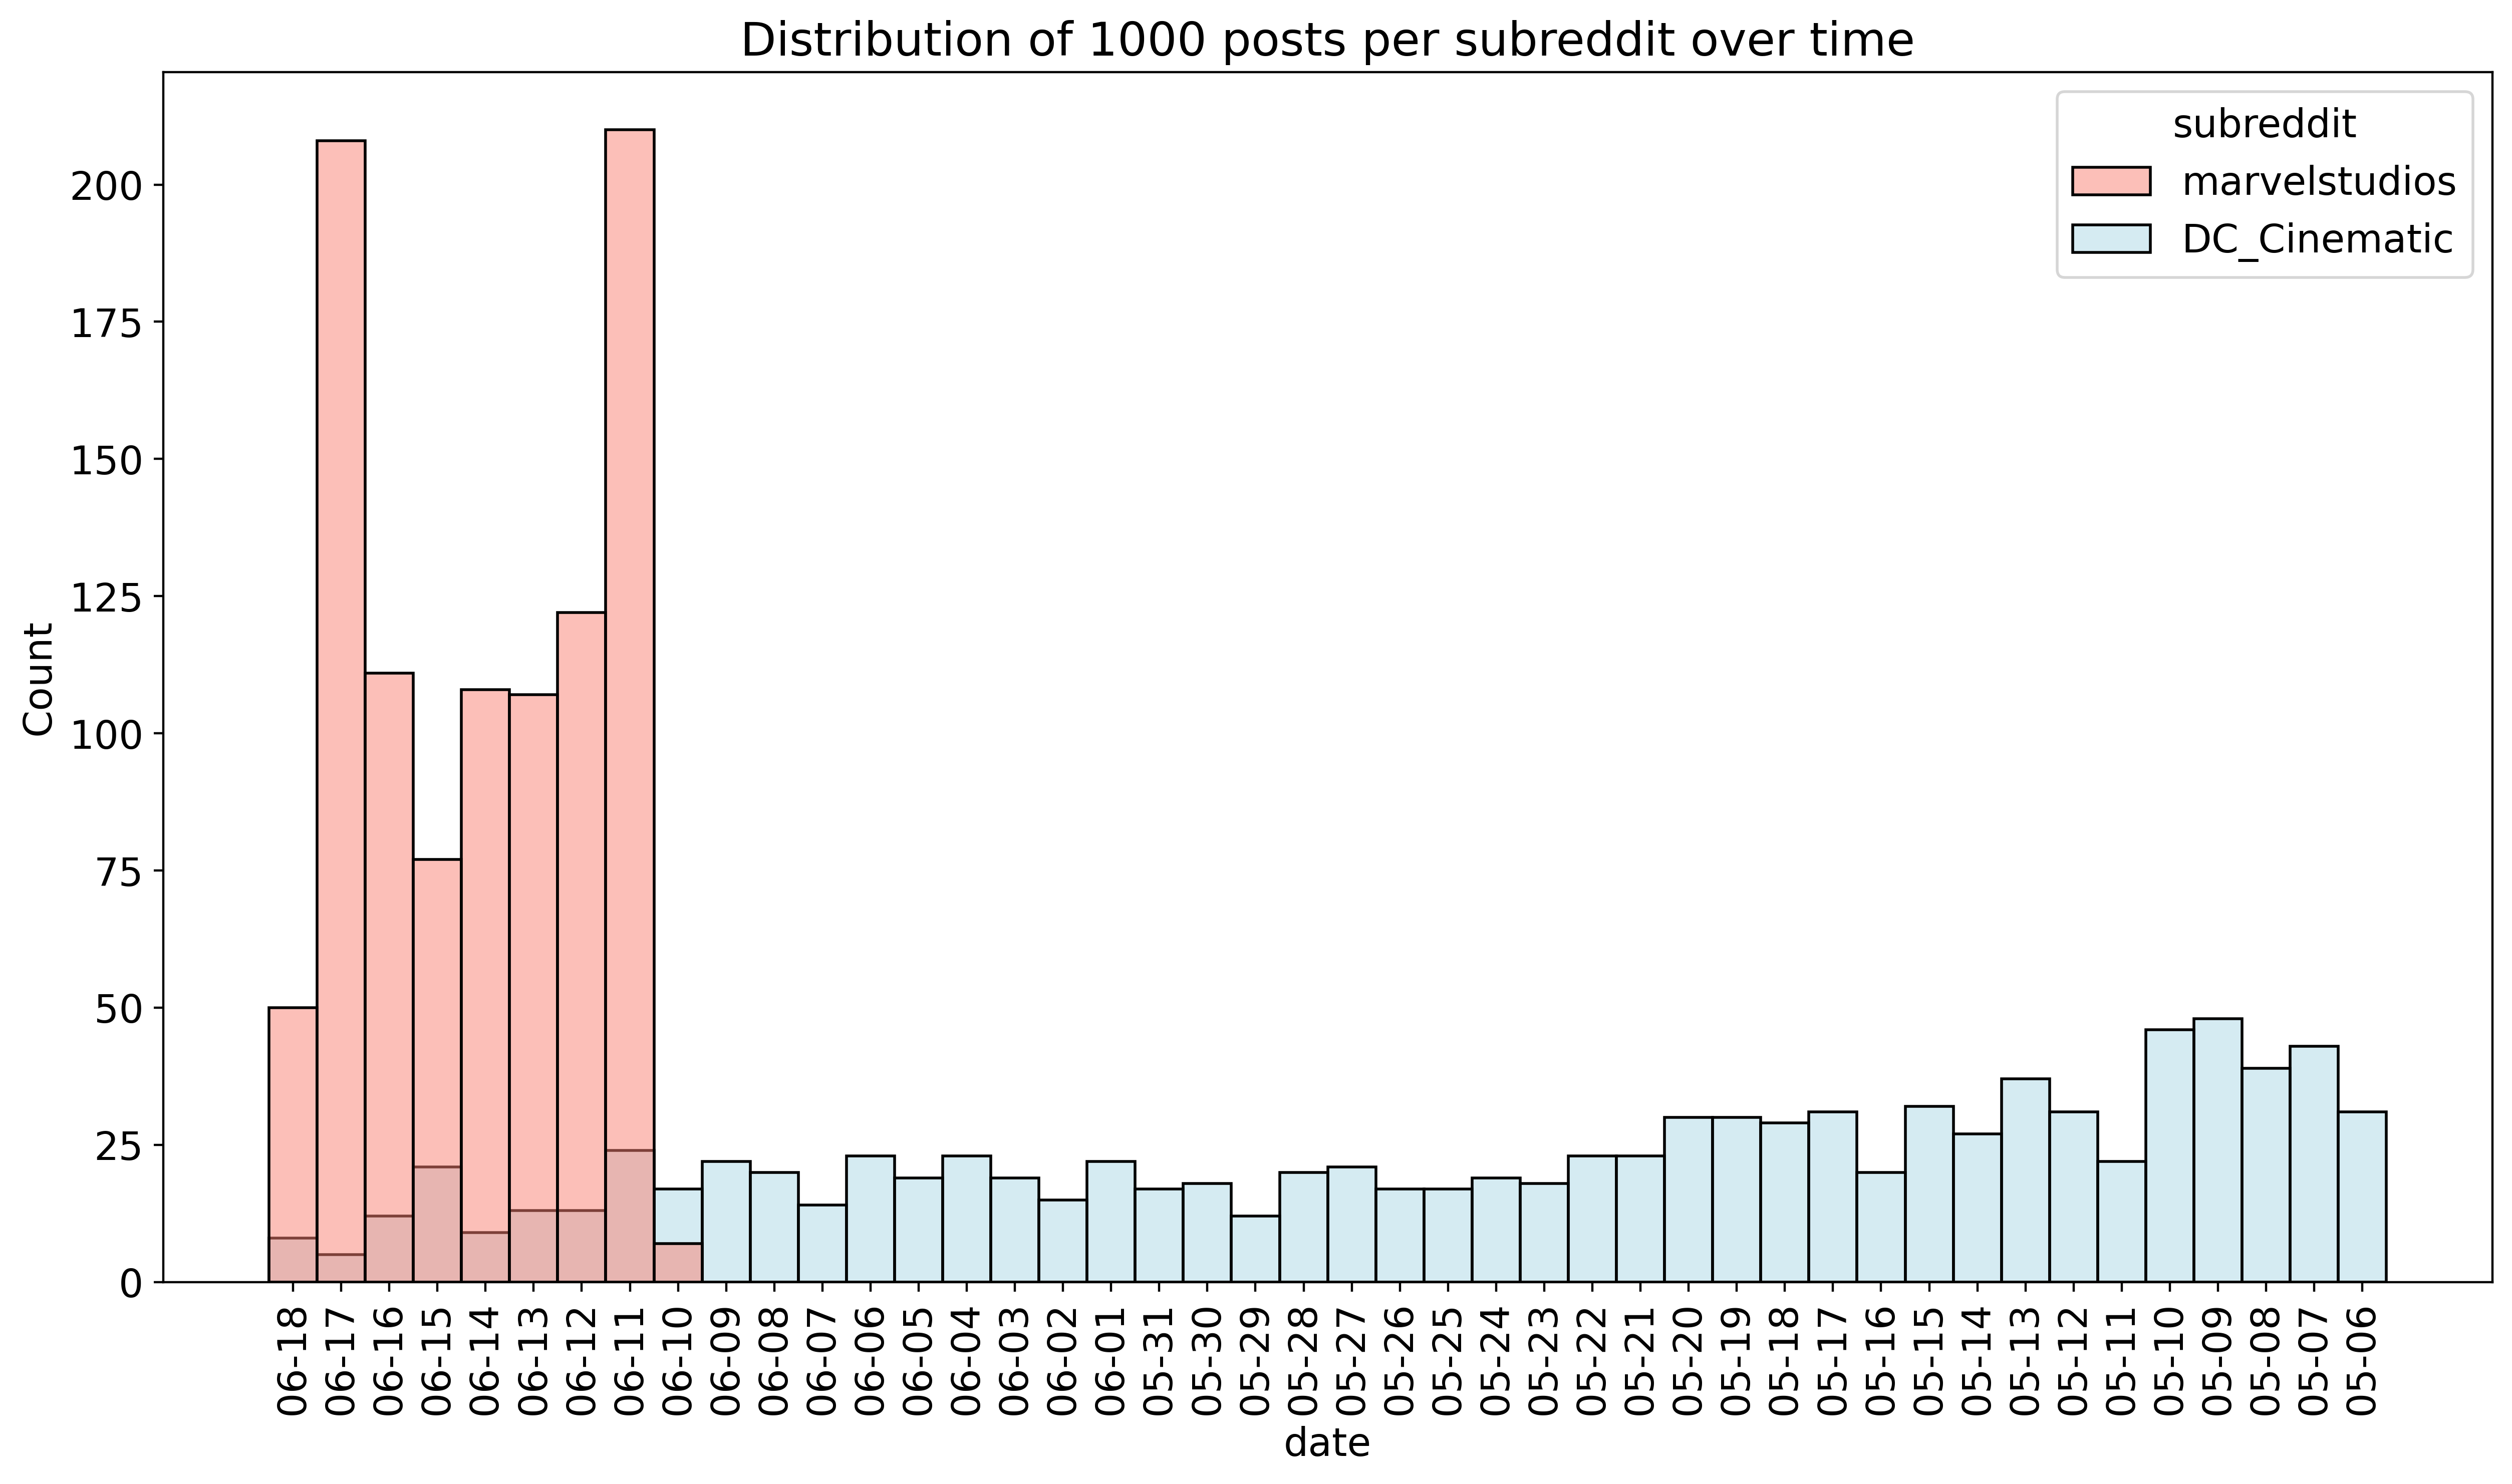

In [82]:
# Post distribution for Marvel and DC 
plt.figure(figsize=(15,8), facecolor='white', dpi=400)
plot=sns.histplot(data=df, x=df['date'].sort_values(ascending=False),hue=df['subreddit'],legend=True,bins = 1000,palette=["salmon", "lightblue"])
plt.title('Distribution of 1000 posts per subreddit over time')
plt.setp(plot.get_xticklabels(), rotation=90);

#### Note: 
- The graph shows the time distribution to collect 1000 post from the subreddit. 
- Marvel subreddit is able to fetch 1000 post faster than DC subreddit. 
- Marvel subreddit is more active as compared to DC recently. 

In [83]:
# Do a final check on the data 
# Checking for dtype and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    2000 non-null   object
 1   title        2000 non-null   object
 2   selftext     2000 non-null   object
 3   created_utc  2000 non-null   int64 
 4   id           2000 non-null   object
 5   target       2000 non-null   int64 
 6   text         2000 non-null   object
 7   date         2000 non-null   object
dtypes: int64(2), object(6)
memory usage: 125.1+ KB


## Data Cleaning and Pre-processing Text data

Below are the steps taken for pre-processing with text data:

- Remove special characters by regular expression
- Tokenizing
- Lemmatizing/Stemming
- Stop word removal


In [84]:
# ntlk library of english stop words package
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [85]:
len(stopwords.words('english'))

179

### Difference between Lemmatizing and Stemming

In [86]:
# To remove special characters , lemmatizing and stop word removal 
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def clean_lemmatize(text):
    # Lowercase all the words
    text=text.lower()
    # Removed HTLM special entities
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https\S+|http\S+', '', text)
    # Remove websites
    text = re.sub(r'www\S+\/\/.*\/\w*', '', text)
    # Remove reddit character code for a zero-width space
    text = re.sub(r'(\w\d{3}\w)', '', text)
    # Remove punctuation and split 's, 't, 've with a space for filter
    text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
    # Remove whitespace 
    text = re.sub(r'\s\s+', ' ', text)
    # Remove new line
    text = re.sub(r'\n+', ' ', text)
    # Remove numbers 
    text = re.sub(r'\d+', ' ', text) 
    # Split sentence
    words = text.split()
    # stopwords from nltk corpus
    stops = set(stop_words)
    # Lemmatizing and Remove Stopwords
    meaningful_words = [lemmatizer.lemmatize(w) for w in words if w not in stops]
    return(' '.join(meaningful_words))

In [87]:
df['text_clean'] = df['text'].apply(clean_lemmatize)

In [88]:
# To remove special characters , stemming and stop word removal 
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
def clean_stem(text):
    # Lowercase all the words
    text=text.lower()
    # Removed HTLM special entities
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https\S+|http\S+', '', text)
    # Remove websites
    text = re.sub(r'www\S+\/\/.*\/\w*', '', text)
    # Remove reddit character code for a zero-width space
    text = re.sub(r'(\w\d{3}\w)', '', text)
    # Remove punctuation and split 's, 't, 've with a space for filter
    text = re.sub(r'[' + string.punctuation.replace('@', '') + ']+', ' ', text)
    # Remove whitespace 
    text = re.sub(r'\s\s+', ' ', text)
    # Remove new line
    text = re.sub(r'\n+', ' ', text)
    # Remove numbers 
    text = re.sub(r'\d+', ' ', text) 
    # Split sentence
    words = text.split()
    # stopwords from nltk corpus
    stops = set(stop_words)
    # Stemming and Remove Stopwords
    meaningful_words = [stemmer.stem(w) for w in words if w not in stops]
    return(' '.join(meaningful_words))

In [89]:
df['text_clean_stem'] = df['text'].apply(clean_stem)

In [90]:
# Text before cleaning (lemmatizing)
print( 'The length of index 40 before lem_cleaning is :', len(df['text'][40].split()))
print( 'The length of index 40 after lem_cleaning is :', len(df['text_clean'][40].split()))

The length of index 40 before lem_cleaning is : 334
The length of index 40 after lem_cleaning is : 156


In [91]:
# Text before cleaning (stemming)
print( 'The length of index 40 before stem_cleaning is :', len(df['text'][40].split()))
print( 'The length of index 40 after stem_cleaning is :' ,len(df['text_clean_stem'][40].split()))

The length of index 40 before stem_cleaning is : 334
The length of index 40 after stem_cleaning is : 156


In [92]:
df['wordcount']= df['text_clean'].str.split().str.len()
df.head()

subreddit                                              title  \
0  marvelstudios                 Spider multiverse and LoKi TVA ...   
1  marvelstudios  My guess on how Loki will end and lead into th...   
2  marvelstudios                       Excuse me what? Partial rant   
3  marvelstudios                             Joe Biden had too much   
4  marvelstudios  So if there's only a single timeline, how are ...   

                                            selftext  created_utc      id  \
0  How does the spider multiverse coincide with t...   1623961657  o26yrt   
1  First up I'm sure I'm not the first person to ...   1623961646  o26ymh   
2  Ok so we watched the first episode of loki and...   1623961252  o26tbi   
3                                          [removed]   1623960897  o26o25   
4                                                      1623960476  o26hkv   

   target                                               text   date  \
0       1  Spider multiverse and LoKi TVA ... How does th...  06-18   
1       1  My guess on how Loki will end and lead into th...  06-18   
2       1  Excuse me what? Partial rant Ok so we watched ...  06-18   
3       1                   Joe Biden had too much [removed]  06-18   
4       1  So if there's only a single timeline, how are ...  06-18   

                                          text_clean  \
0  spider multiverse loki tva spider multiverse c...   
1  guess loki end lead multiverse first sure firs...   
2  excuse partial rant ok watched first episode l...   
3                             joe biden much removed   
4        single timeline many different version loki   

                                     text_clean_stem  wordcount  
0  spider multivers loki tva spider multivers coi...          9  
1  guess loki end lead multivers first sure first...        155  
2  excus partial rant ok watch first episod loki ...         36  
3                               joe biden much remov          4  
4             singl timelin mani differ version loki          6

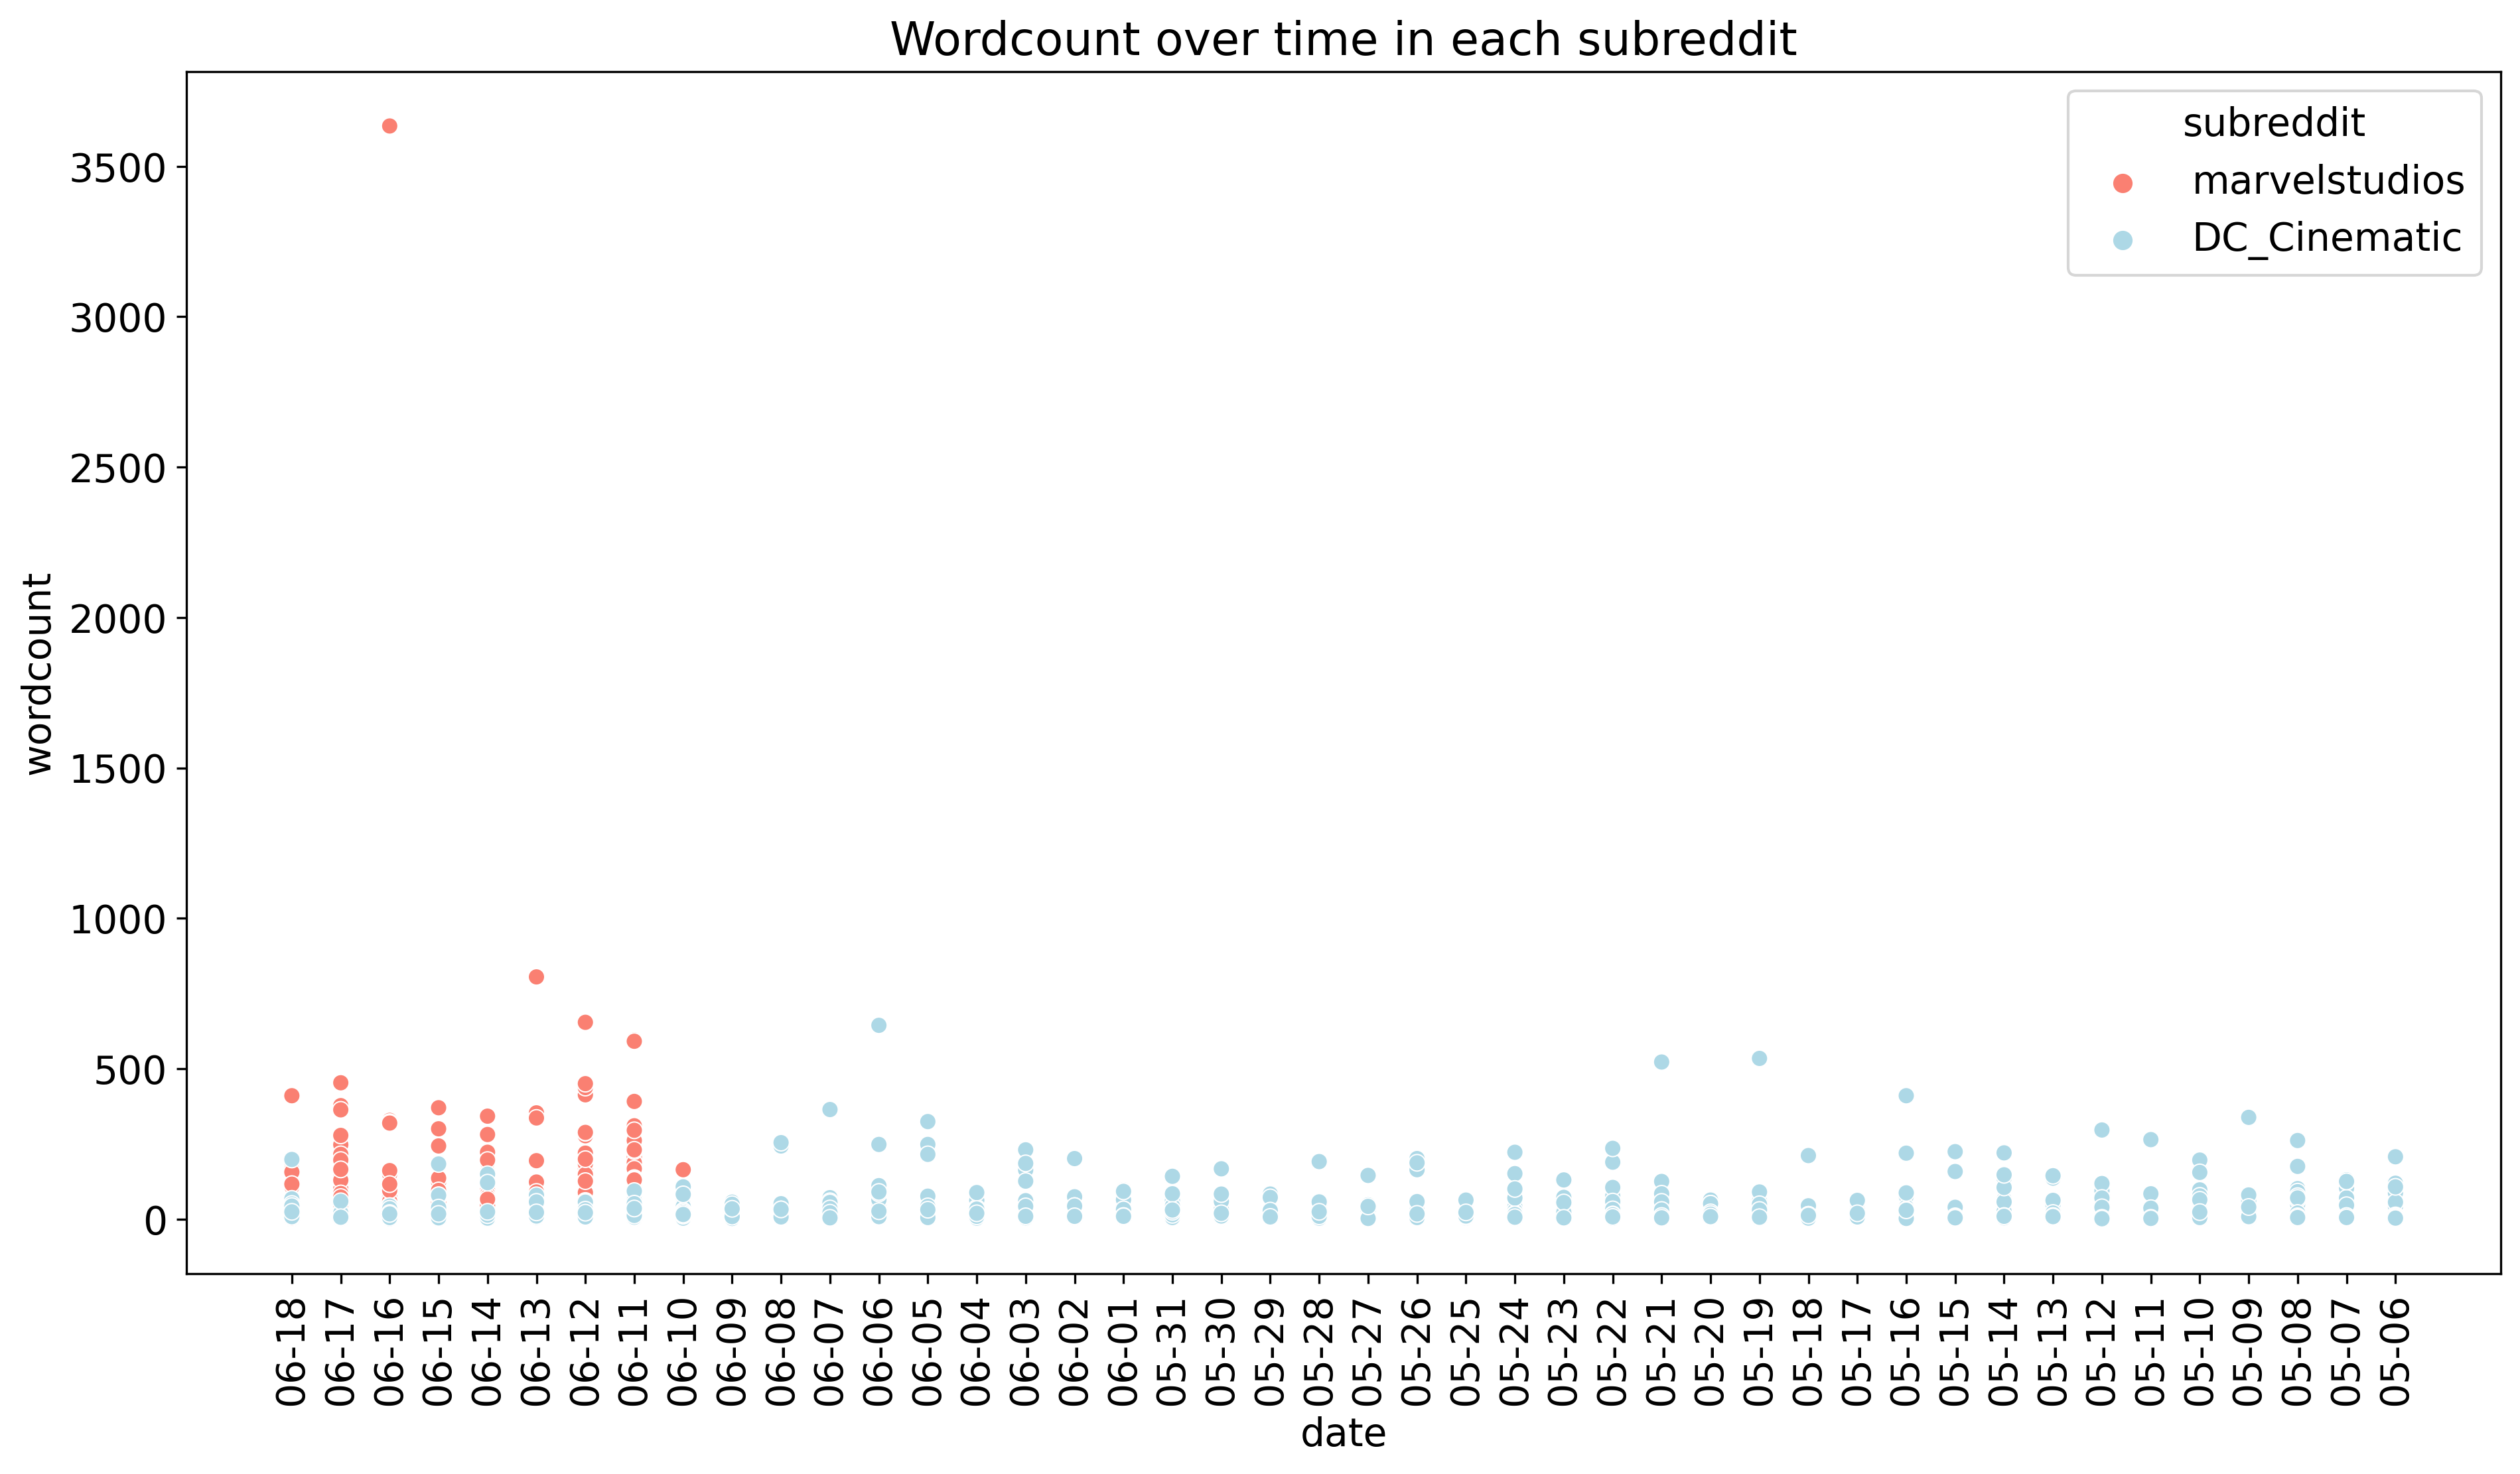

In [93]:
# Plot the wordcount over time in each subreddit
plt.figure(figsize=(15,8), facecolor='white', dpi=300)
plot=sns.scatterplot(data=df, x="date", y="wordcount",hue='subreddit',palette=["salmon", "lightblue"])
plt.title('Wordcount over time in each subreddit')
plt.setp(plot.get_xticklabels(), rotation=90);

#### Note: 
- Marvel subbreddit is more active with more words as compared to dc subreddit.
- Marvel population is more than DC population

In [94]:
# Check for any null values 
df.isnull().sum()

subreddit          0
title              0
selftext           0
created_utc        0
id                 0
target             0
text               0
date               0
text_clean         0
text_clean_stem    0
wordcount          0
dtype: int64

In [95]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer()

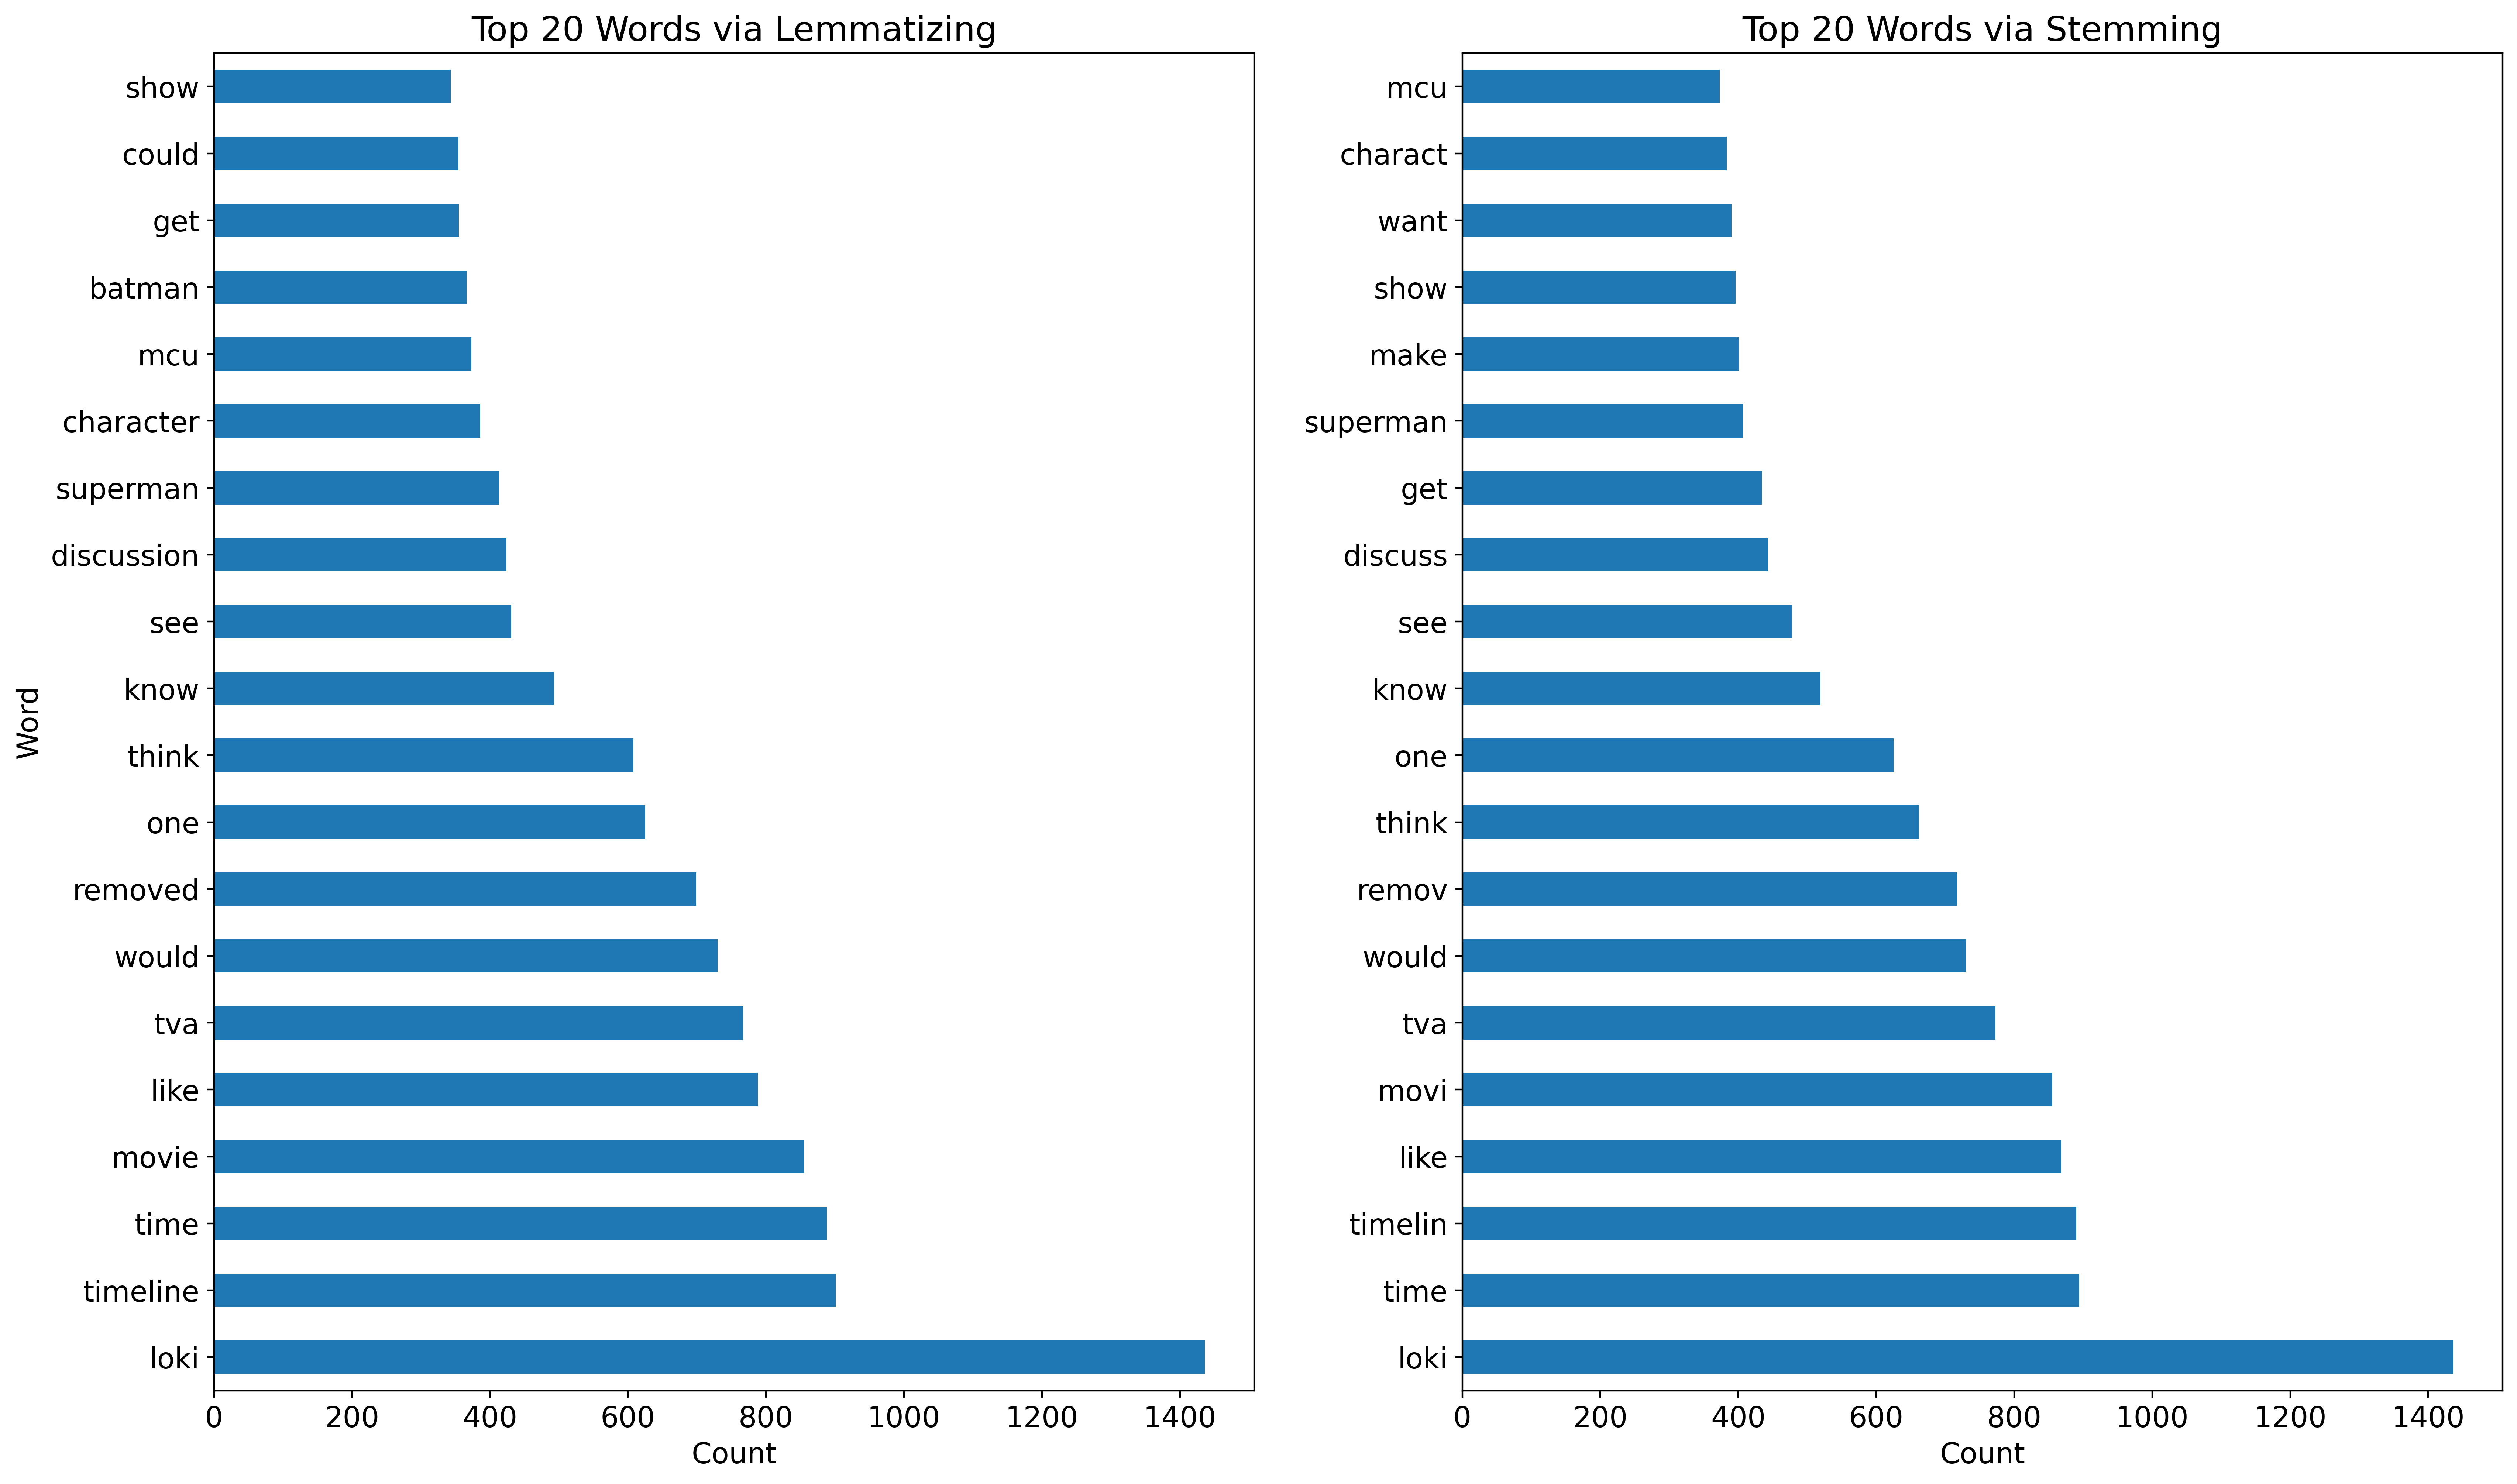

In [96]:
# Stemming VS Lemmatising

# CountVectoriser for lemmatised words
input_lem=df['text_clean']
# Fit transform & Get feature names
lem = pd.DataFrame(cvec.fit_transform(input_lem).todense(), 
                          columns=cvec.get_feature_names())
# Sorting the top words by CountVectoriser
lem.sum().sort_values(ascending=False)


# CountVectoriser for stemmed words
input_stem=df['text_clean_stem']
# Fit transform & Get feature names
stem = pd.DataFrame(cvec.fit_transform(input_stem).todense(), 
                          columns=cvec.get_feature_names())
# Sorting the top words by CountVectoriser
stem.sum().sort_values(ascending=False)


# Plot graph for top 20 words for CountVectorizer and TF-IDFVectorizer
plt.figure(figsize=(20,12), facecolor='white', dpi=400)

# Lemmatizing
plt.subplot(1,2,1)
lem.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Words via Lemmatizing')
plt.xlabel('Count')
plt.ylabel('Word')
plt.rc('font',size=14)

# Stemming
plt.subplot(1,2,2)
stem.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Words via Stemming')
plt.xlabel('Count')
#plt.ylabel('Word')
plt.rc('font',size=14)

#### Observations: 
- Both stemming and lemmatizing generate the root form of the words. 
- The difference is stem might not be an actual word whereas lemmatizing is an actual language word. 
- Some of the words are brutual trimmed off by stemming, example character become charact , timeline become timelin.
- Stop words/meaningless words will not be removed after stemming as the spelling for the same word might have change.
- Therefore, lemmatizing will be used in this project as Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma.
- We can also observe that the data collected is useful and relevant to marvel and dc. We can see words like Loki, superman. However, we need to clean more words to have a clearer picture.

#### To examine the top 50 words for each of the subbreddits : Marvelstudio and DC_cinematics

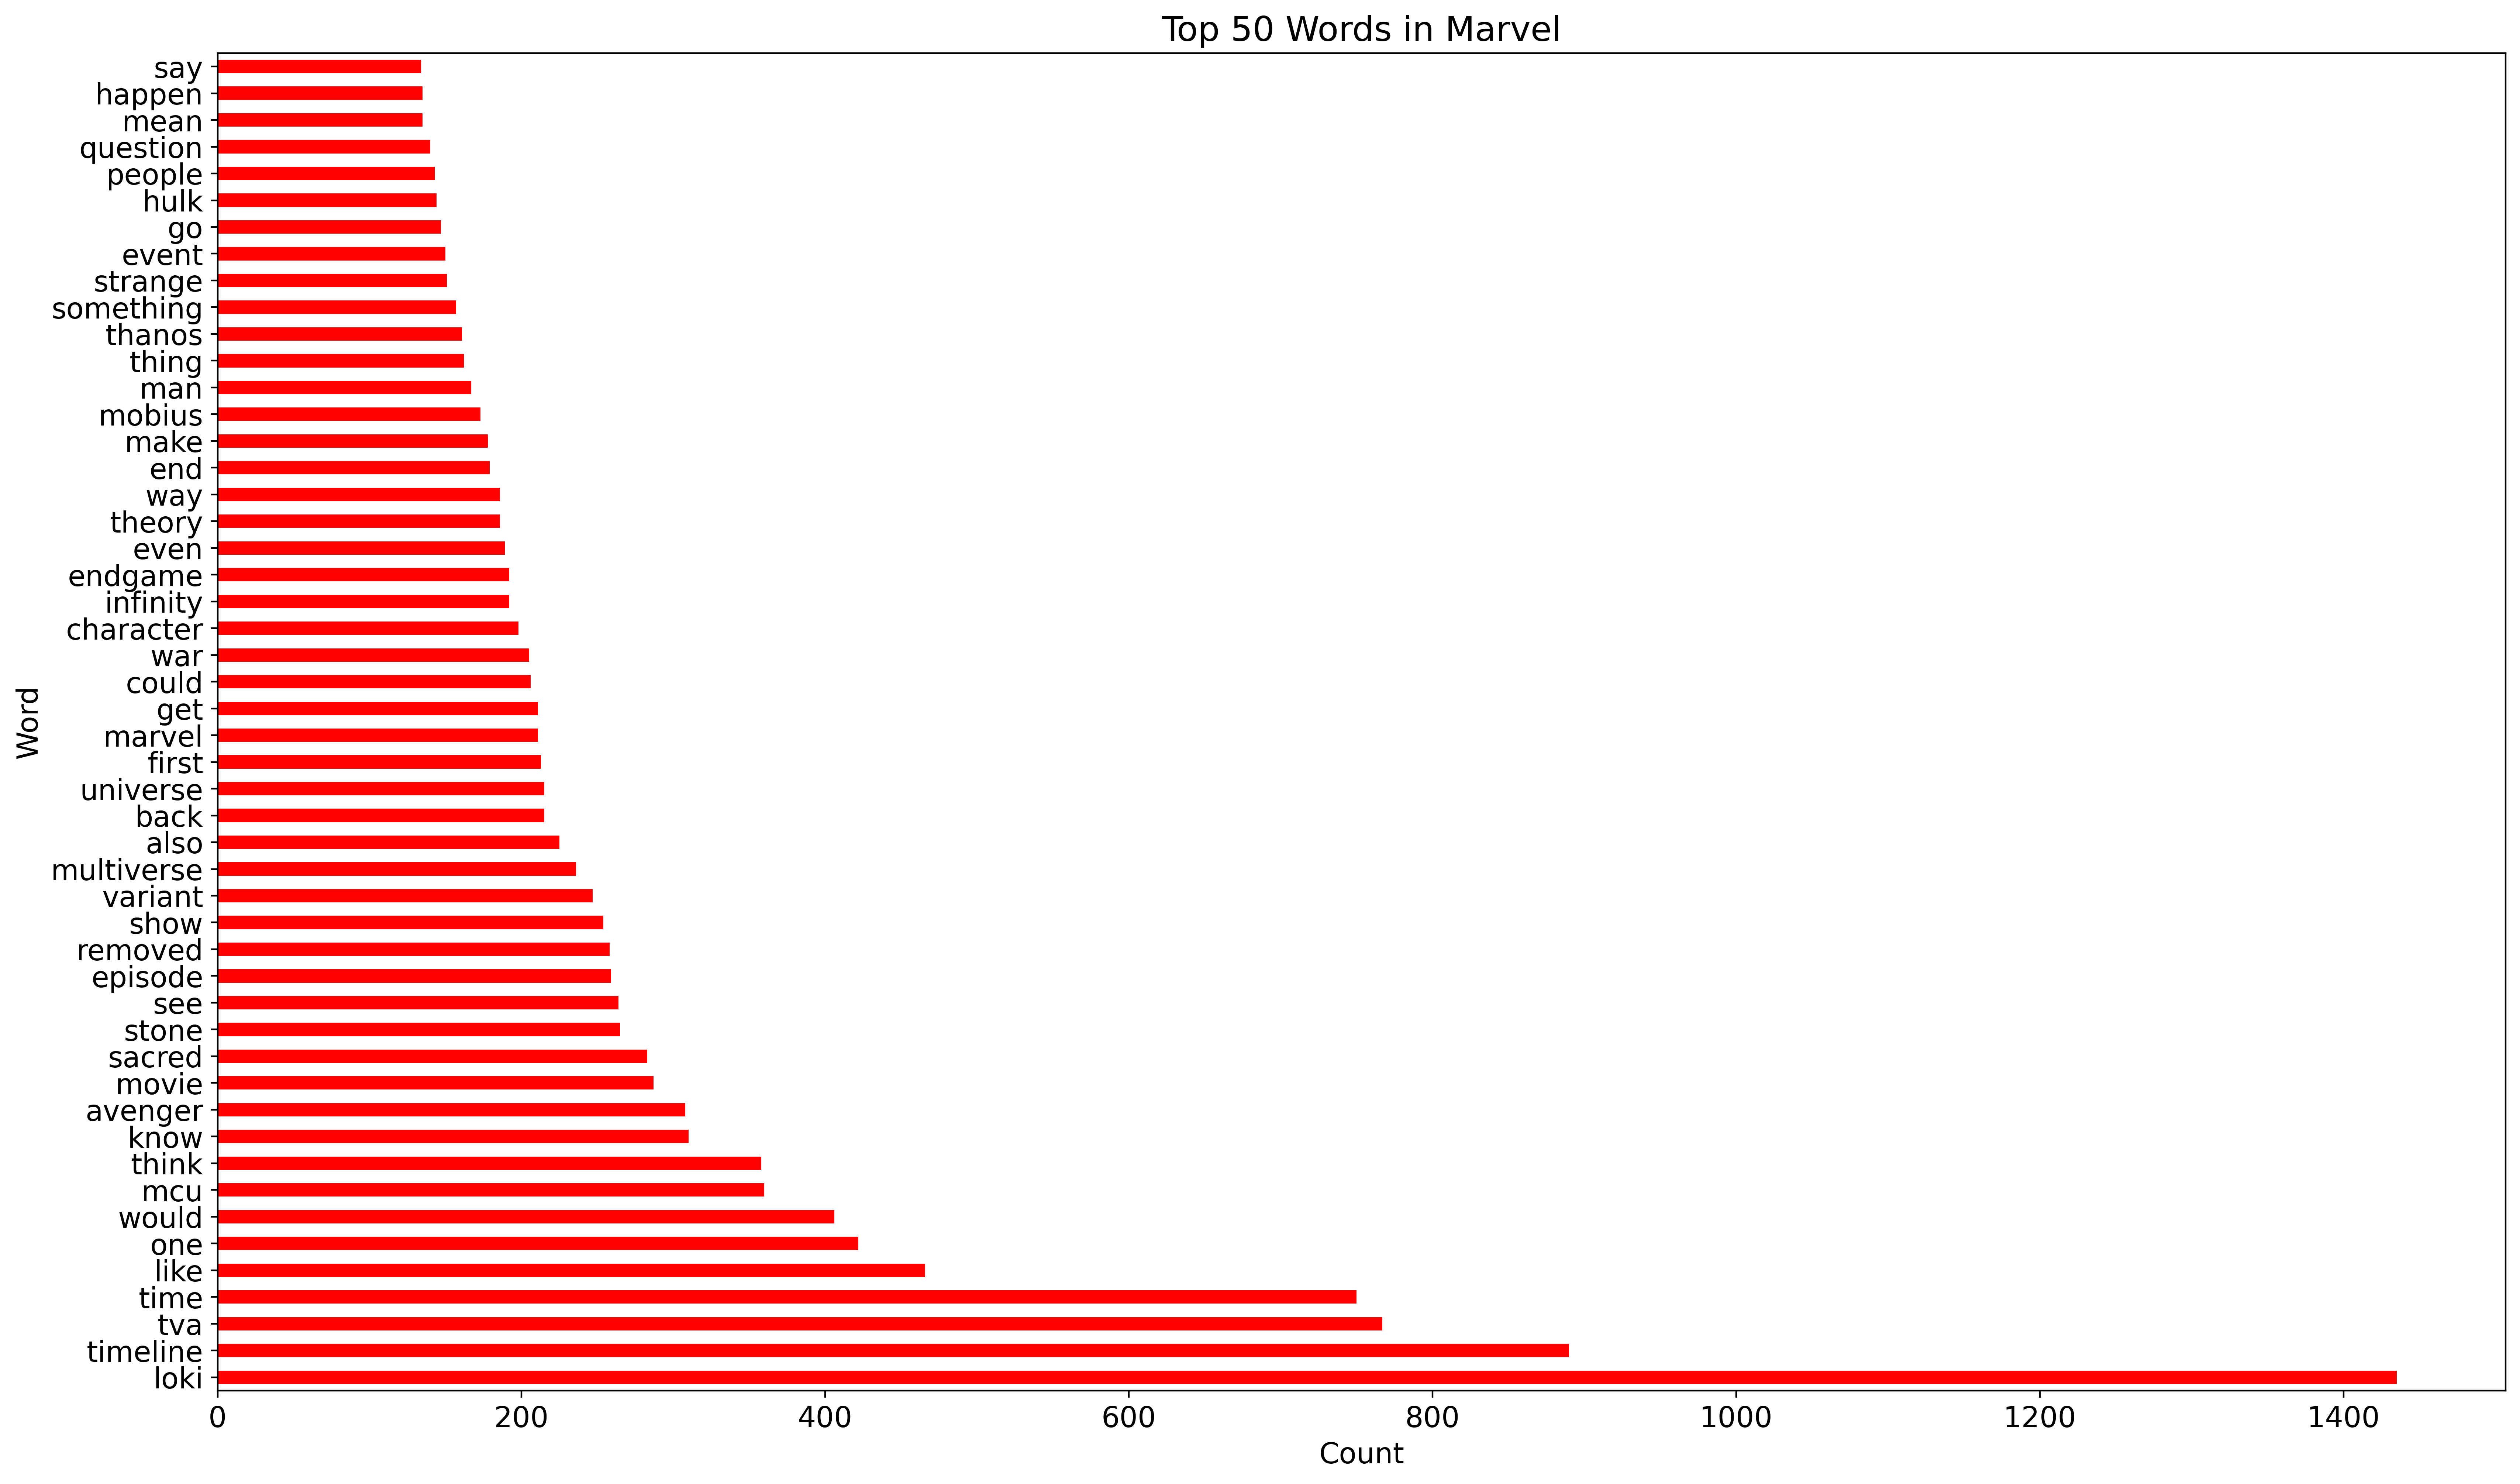

In [30]:
# Marvel data
# Input for CountVectoriser
input_marvel=df[df['target']==1]['text_clean']

# Fit transform 
marvel_words = cvec.fit_transform(input_marvel)

# Get features 
marvel_list=cvec.get_feature_names()

df_marvel = pd.DataFrame(marvel_words.todense(), 
                          columns=marvel_list)

plt.figure(figsize=(20,12), facecolor='white', dpi=400)
df_marvel.sum().sort_values(ascending=False).head(50).plot(kind='barh',cmap='hsv')
plt.title('Top 50 Words in Marvel')
plt.xlabel('Count')
plt.ylabel('Word');

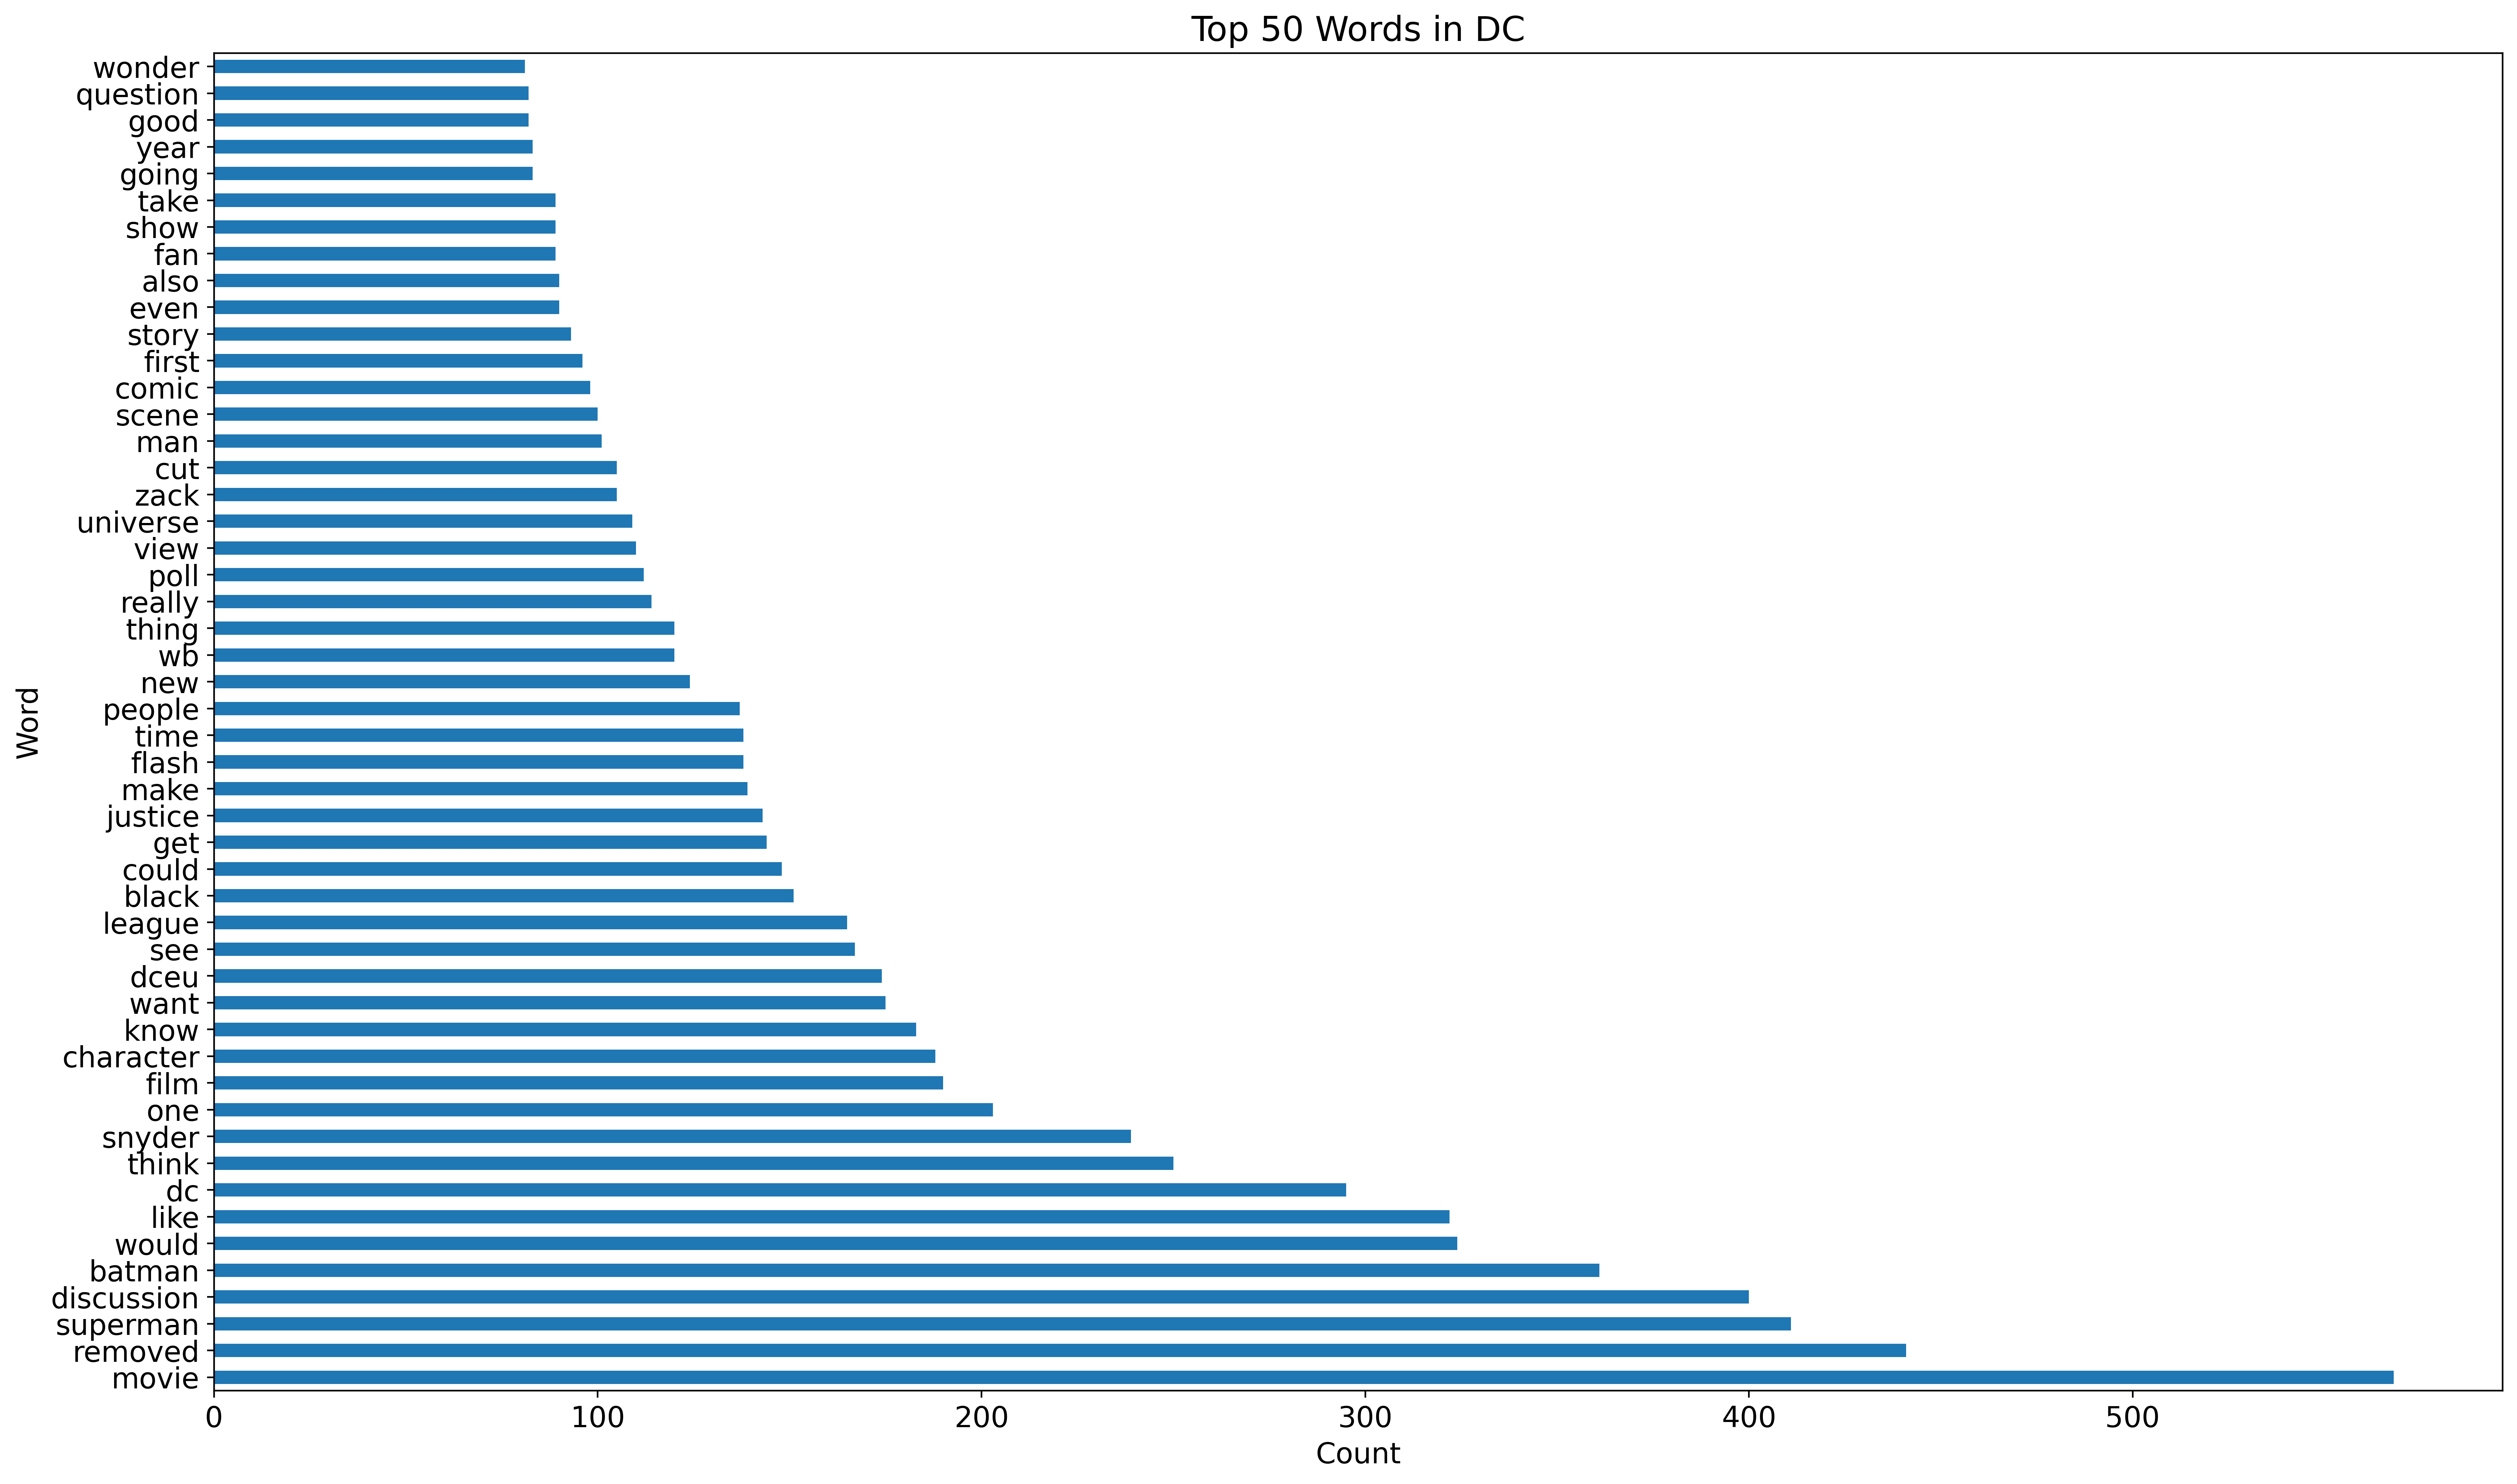

In [31]:
# DC data
# Input for CountVectoriser 
input_dc=df[df['target']==0]['text_clean']

# Fit transform 
dc_words = cvec.fit_transform(input_dc)

# Get features
dc_list=cvec.get_feature_names()

df_dc = pd.DataFrame(dc_words.todense(), 
                          columns=dc_list)

plt.figure(figsize=(20,12), facecolor='white', dpi=400)
df_dc.sum().sort_values(ascending=False).head(50).plot(kind='barh')
plt.title('Top 50 Words in DC')
plt.xlabel('Count')
plt.ylabel('Word');

#### Observations: 
- Meaningless words are found in the top 50 words in both subreddits as they do not help in differentiating classes of the text which will not address the problem statement. 
- Meaningless words are more likely to be connecting words in a sentence.
- To remove them via english stop words from sklearn and additional inputs from the finding above.
- Meaningless words are not considered as outliers. 
- There is no outliers in NLP processing as the important information might not contain the most frequent words and may contain the least frequent word.

In [32]:
# To further clean the meaningless words from another package
from sklearn.feature_extraction import text

text.ENGLISH_STOP_WORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [33]:
# Additional meaningless words taken from EDA to be included in the stop_words

add_english=['like','one','would','think','know','see','show','also','character','could','supposed','year',
             'back','first','get','way','even','make','end','thing','everything','happen','excited',
             'go','movie','time','discussion','film','want','people','new','really','thought','hour','story',
             'scene','cut','fan','good','nan','deleted','say','view','poll','question','going','best','removed']

stop_words=text.ENGLISH_STOP_WORDS.union(add_english)

In [34]:
len(stop_words)

354

### CountVectorizer and TF-IDFVectorizer for 1 word analysis

In [35]:
# Instantiate a CountVectorizer and TF-IDFVectorizer
cvec = CountVectorizer(stop_words=stop_words)
tvec = TfidfVectorizer(stop_words=stop_words)

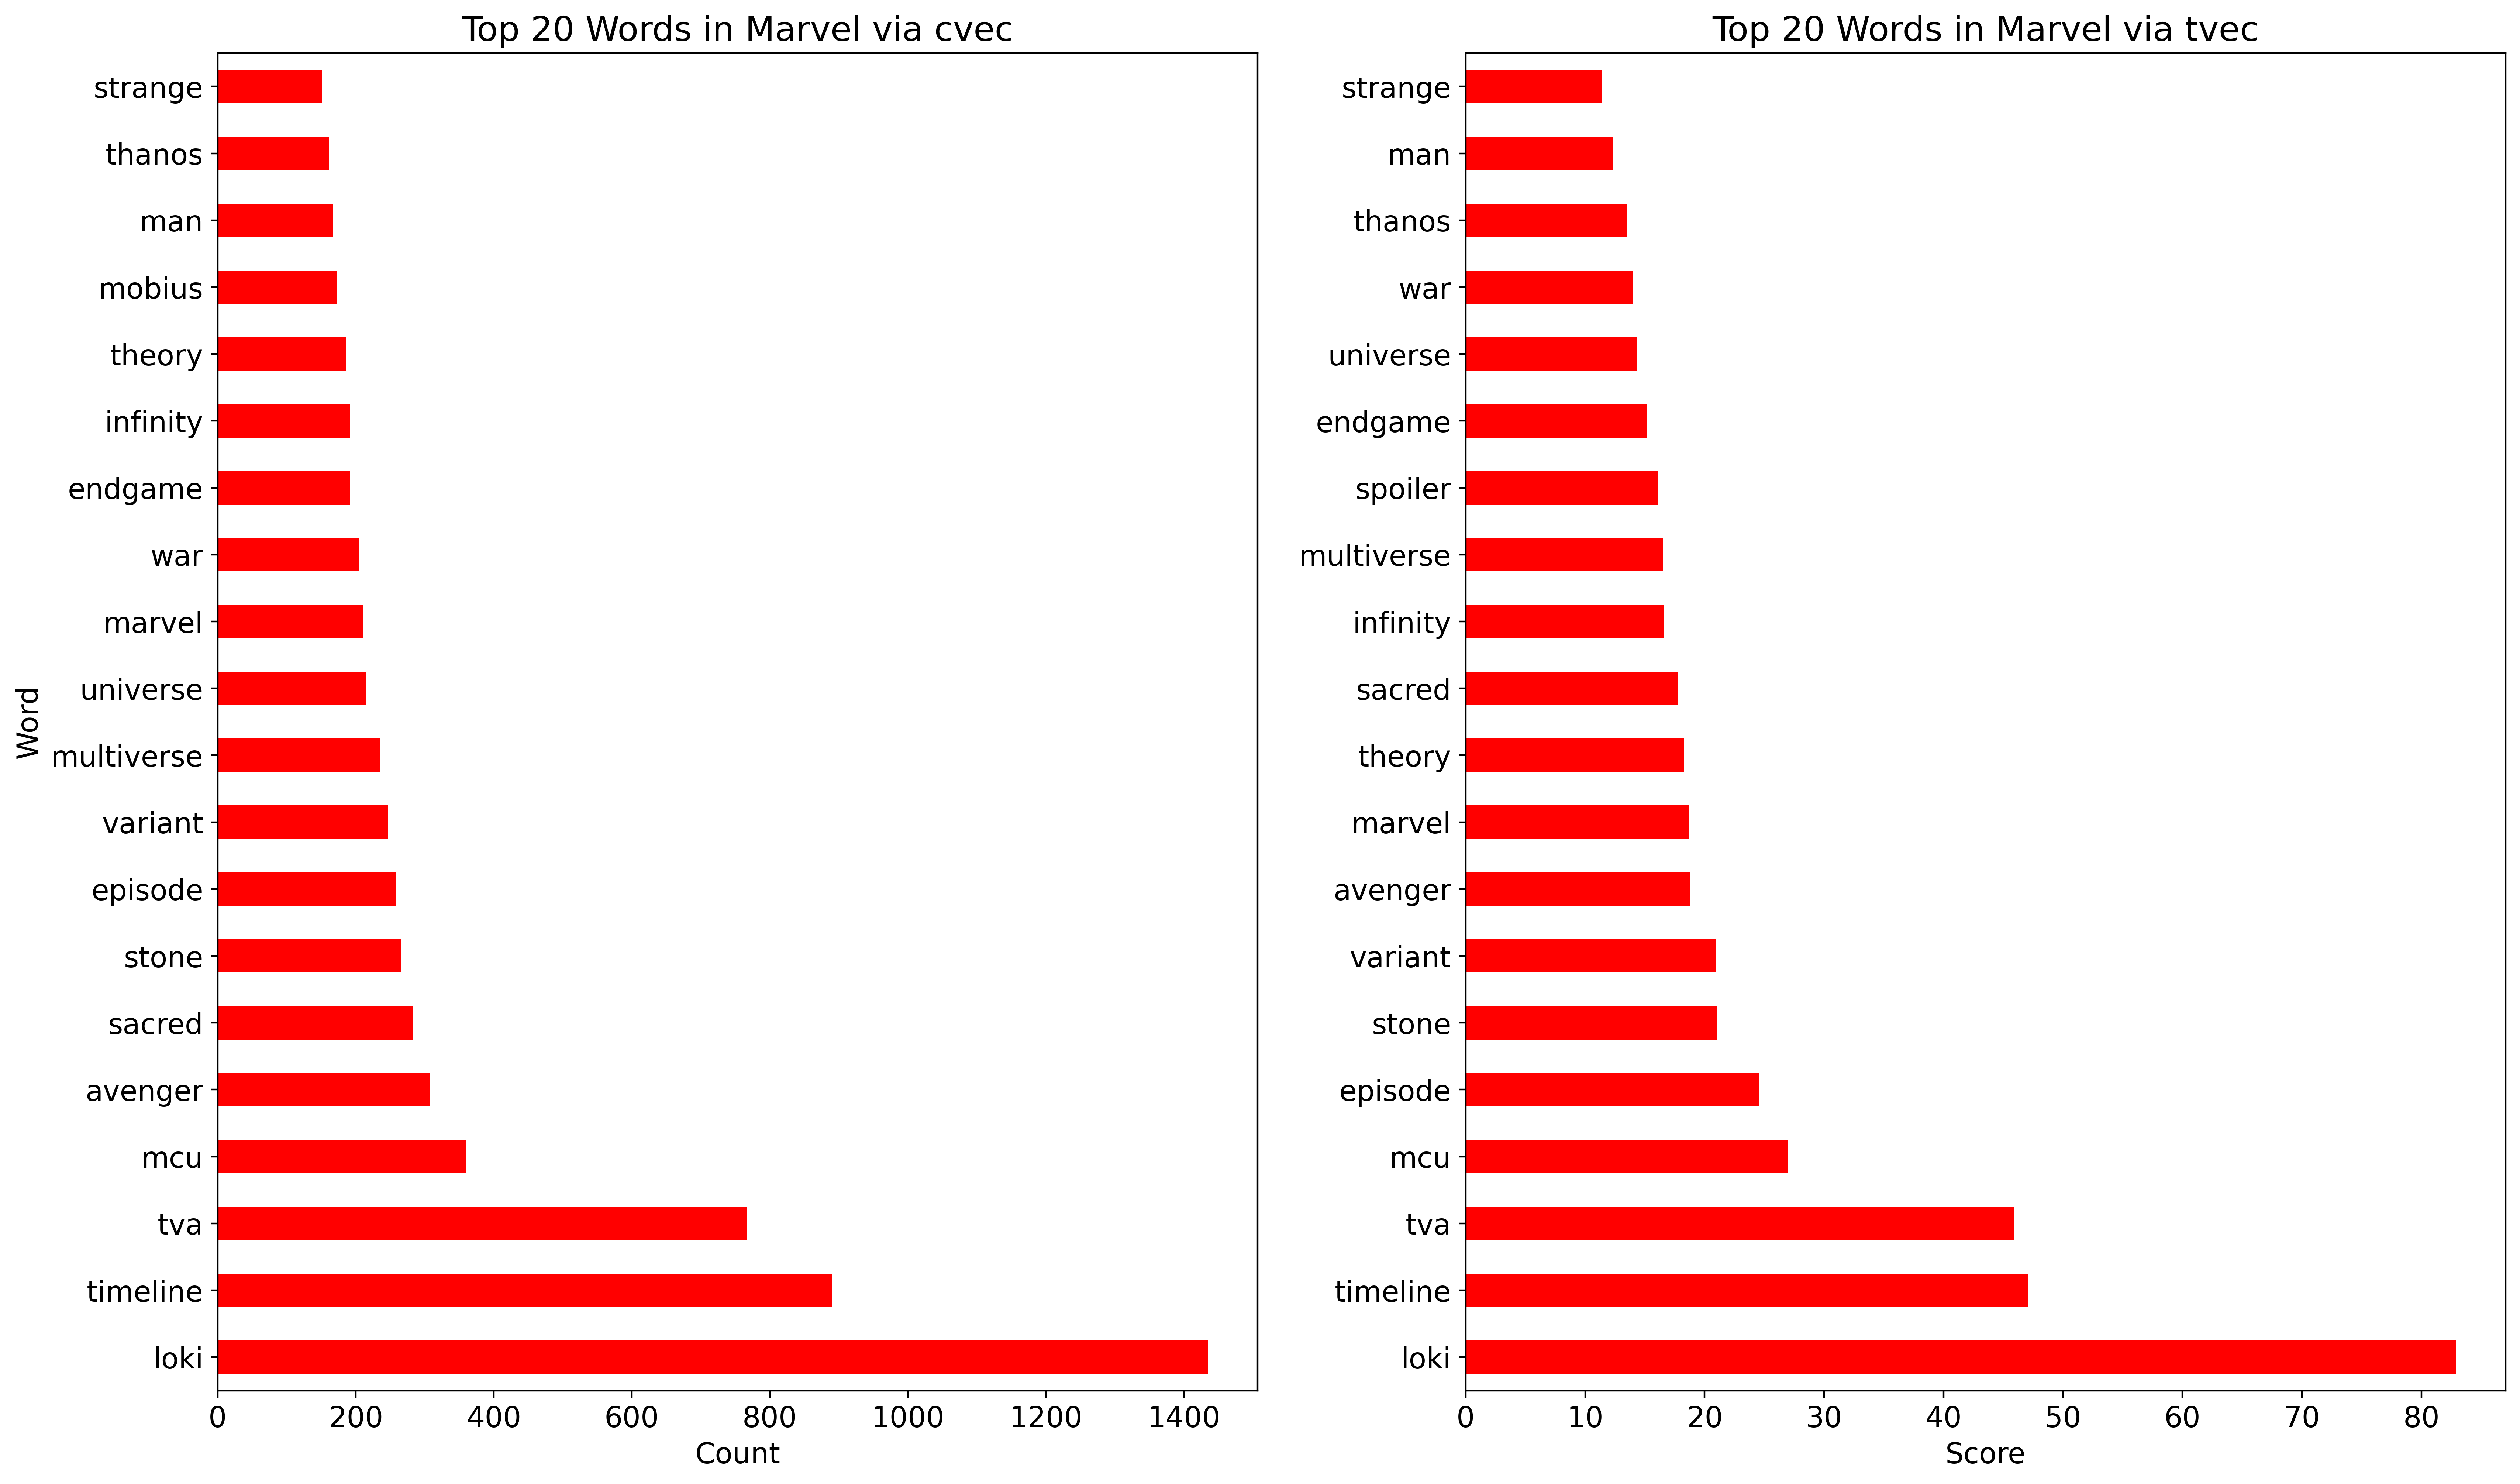

In [36]:
input_marvel=df[df['target']==1]['text_clean']

# CountVectorizer
# Fit transform & Get feature names
marvel_cvec = pd.DataFrame(cvec.fit_transform(input_marvel).todense(), 
                          columns=cvec.get_feature_names())
# Sorting the top words by CountVectoriser
marvel_cvec.sum().sort_values(ascending=False)

# TF-IDFVectorizer
# Fit transform & Get feature names
marvel_tvec = pd.DataFrame(tvec.fit_transform(input_marvel).todense(), 
                          columns=tvec.get_feature_names())
# Sorting the top words by TF-IDFVectorizer
marvel_tvec.sum().sort_values(ascending=False)

# Plot graph for top 20 words for CountVectorizer and TF-IDFVectorizer
plt.figure(figsize=(20,12), facecolor='white', dpi=400)

# CountVectorizer on the left
plt.subplot(1,2,1)
marvel_cvec.sum().sort_values(ascending=False).head(20).plot(kind='barh', cmap='hsv')
plt.title('Top 20 Words in Marvel via cvec')
plt.xlabel('Count')
plt.ylabel('Word')
plt.rc('font',size=14)


# TF-IDFVectoriser on the right
plt.subplot(1,2,2)
marvel_tvec.sum().sort_values(ascending=False).head(20).plot(kind='barh', cmap='hsv')
plt.title('Top 20 Words in Marvel via tvec')
plt.xlabel('Score')
#plt.ylabel('Word')
plt.rc('font',size=14)

#### Observations:
- Most discussed words are easily related to Marvel such as loki.
- With the help of count and score of the words, we can identify the some of the hot topic in marvel as well as most discussed hero as requested in the problem statement.
- No need for additional words to be removed.

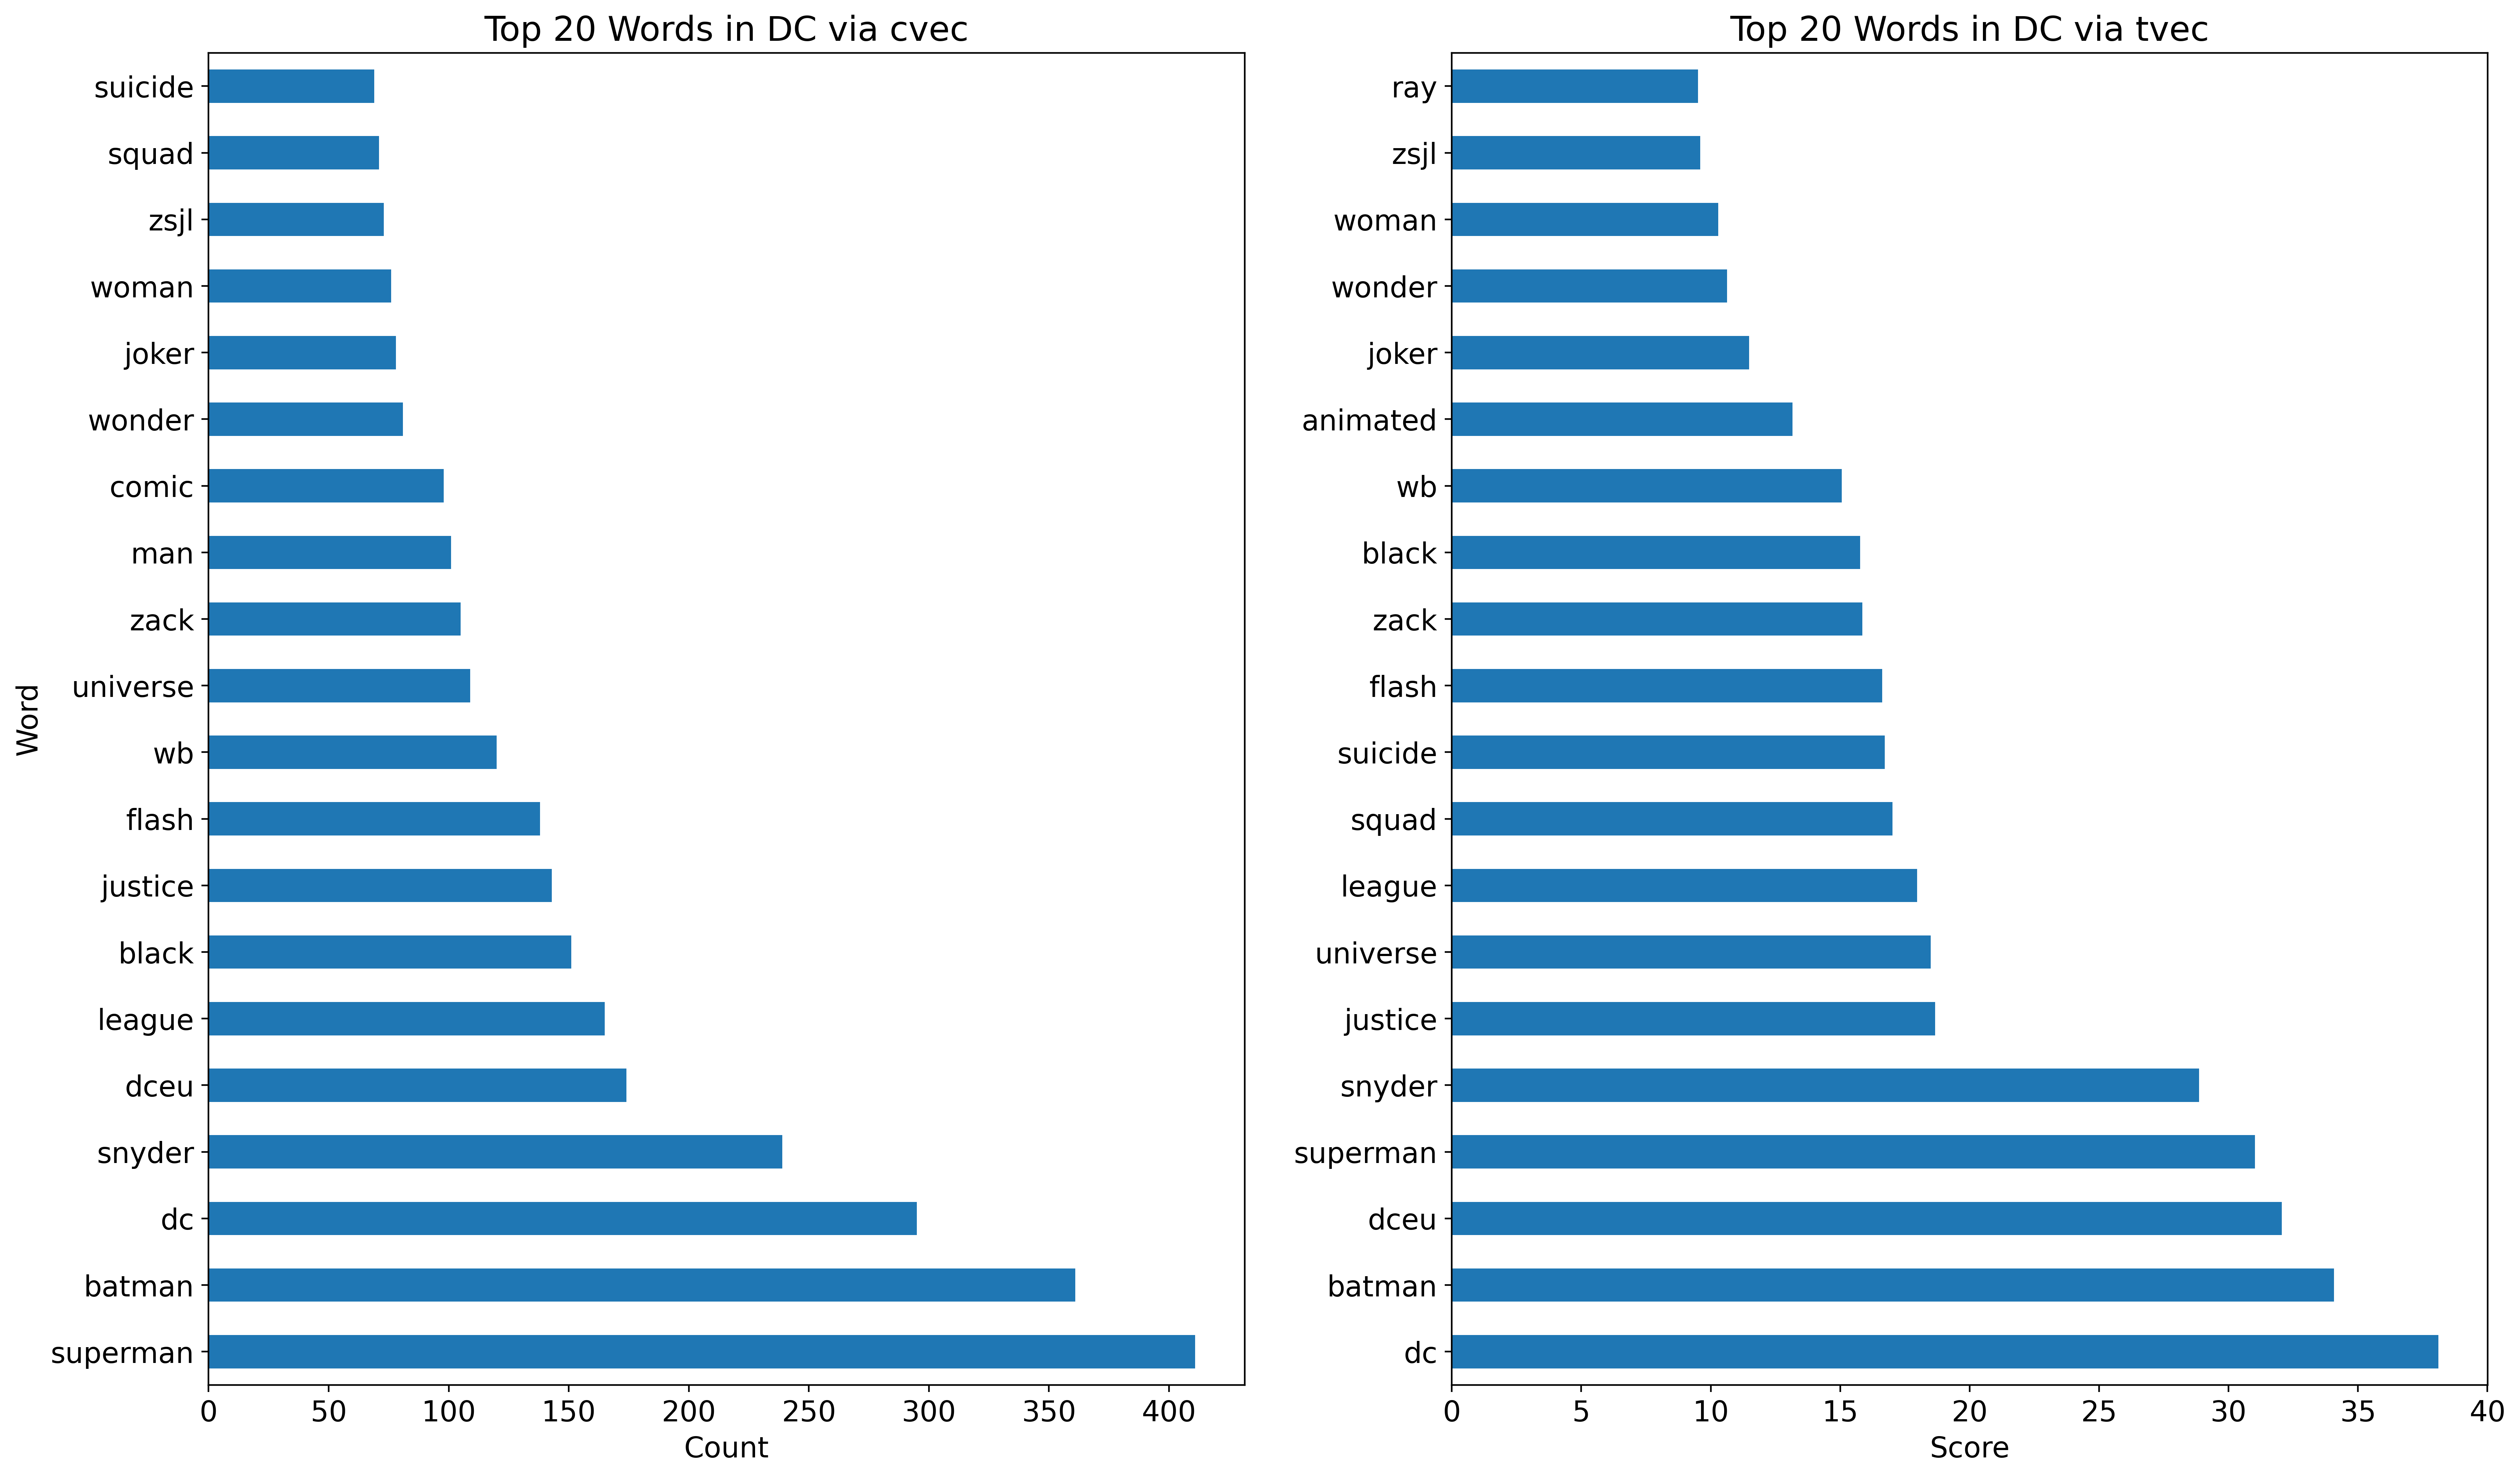

In [37]:
input_dc=df[df['target']==0]['text_clean']

# CountVectorizer
# Fit transform & Get feature names
dc_cvec = pd.DataFrame(cvec.fit_transform(input_dc).todense(), 
                          columns=cvec.get_feature_names())
# Sorting the top words by CountVectoriser
dc_cvec.sum().sort_values(ascending=False)

# TF-IDFVectorizer
# Fit transform & Get feature names
dc_tvec = pd.DataFrame(tvec.fit_transform(input_dc).todense(), 
                          columns=tvec.get_feature_names())
# Sorting the top words by TF-IDFVectorizer
dc_tvec.sum().sort_values(ascending=False)

# Plot graph for top 20 words for CountVectorizer and TF-IDFVectorizer
plt.figure(figsize=(20,12), facecolor='white', dpi=400)

# CountVectorizer on the left
plt.subplot(1,2,1)
dc_cvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Words in DC via cvec')
plt.xlabel('Count')
plt.ylabel('Word')
plt.rc('font',size=14)

# TF-IDFVectoriser on the right
plt.subplot(1,2,2)
dc_tvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Words in DC via tvec')
plt.xlabel('Score')
#plt.ylabel('Word')
plt.rc('font',size=14)

#### Observations:
- Most discussed words are easily related to DC such as superman and batman.
- With the help of count and score of the words, we can identify the some of the hot topic in dc as well as most discussed hero as requested in the problem statement.
- No need for additional words to be removed.

### EDA using CountVectorizer and TF-IDFVectorizer for 2 word analysis

In [38]:
# Instantiate a CountVectorizer and TF-IDFVectorizer
cvec = CountVectorizer(stop_words=stop_words,ngram_range=(2,2))
tvec = TfidfVectorizer(stop_words=stop_words,ngram_range=(2,2))

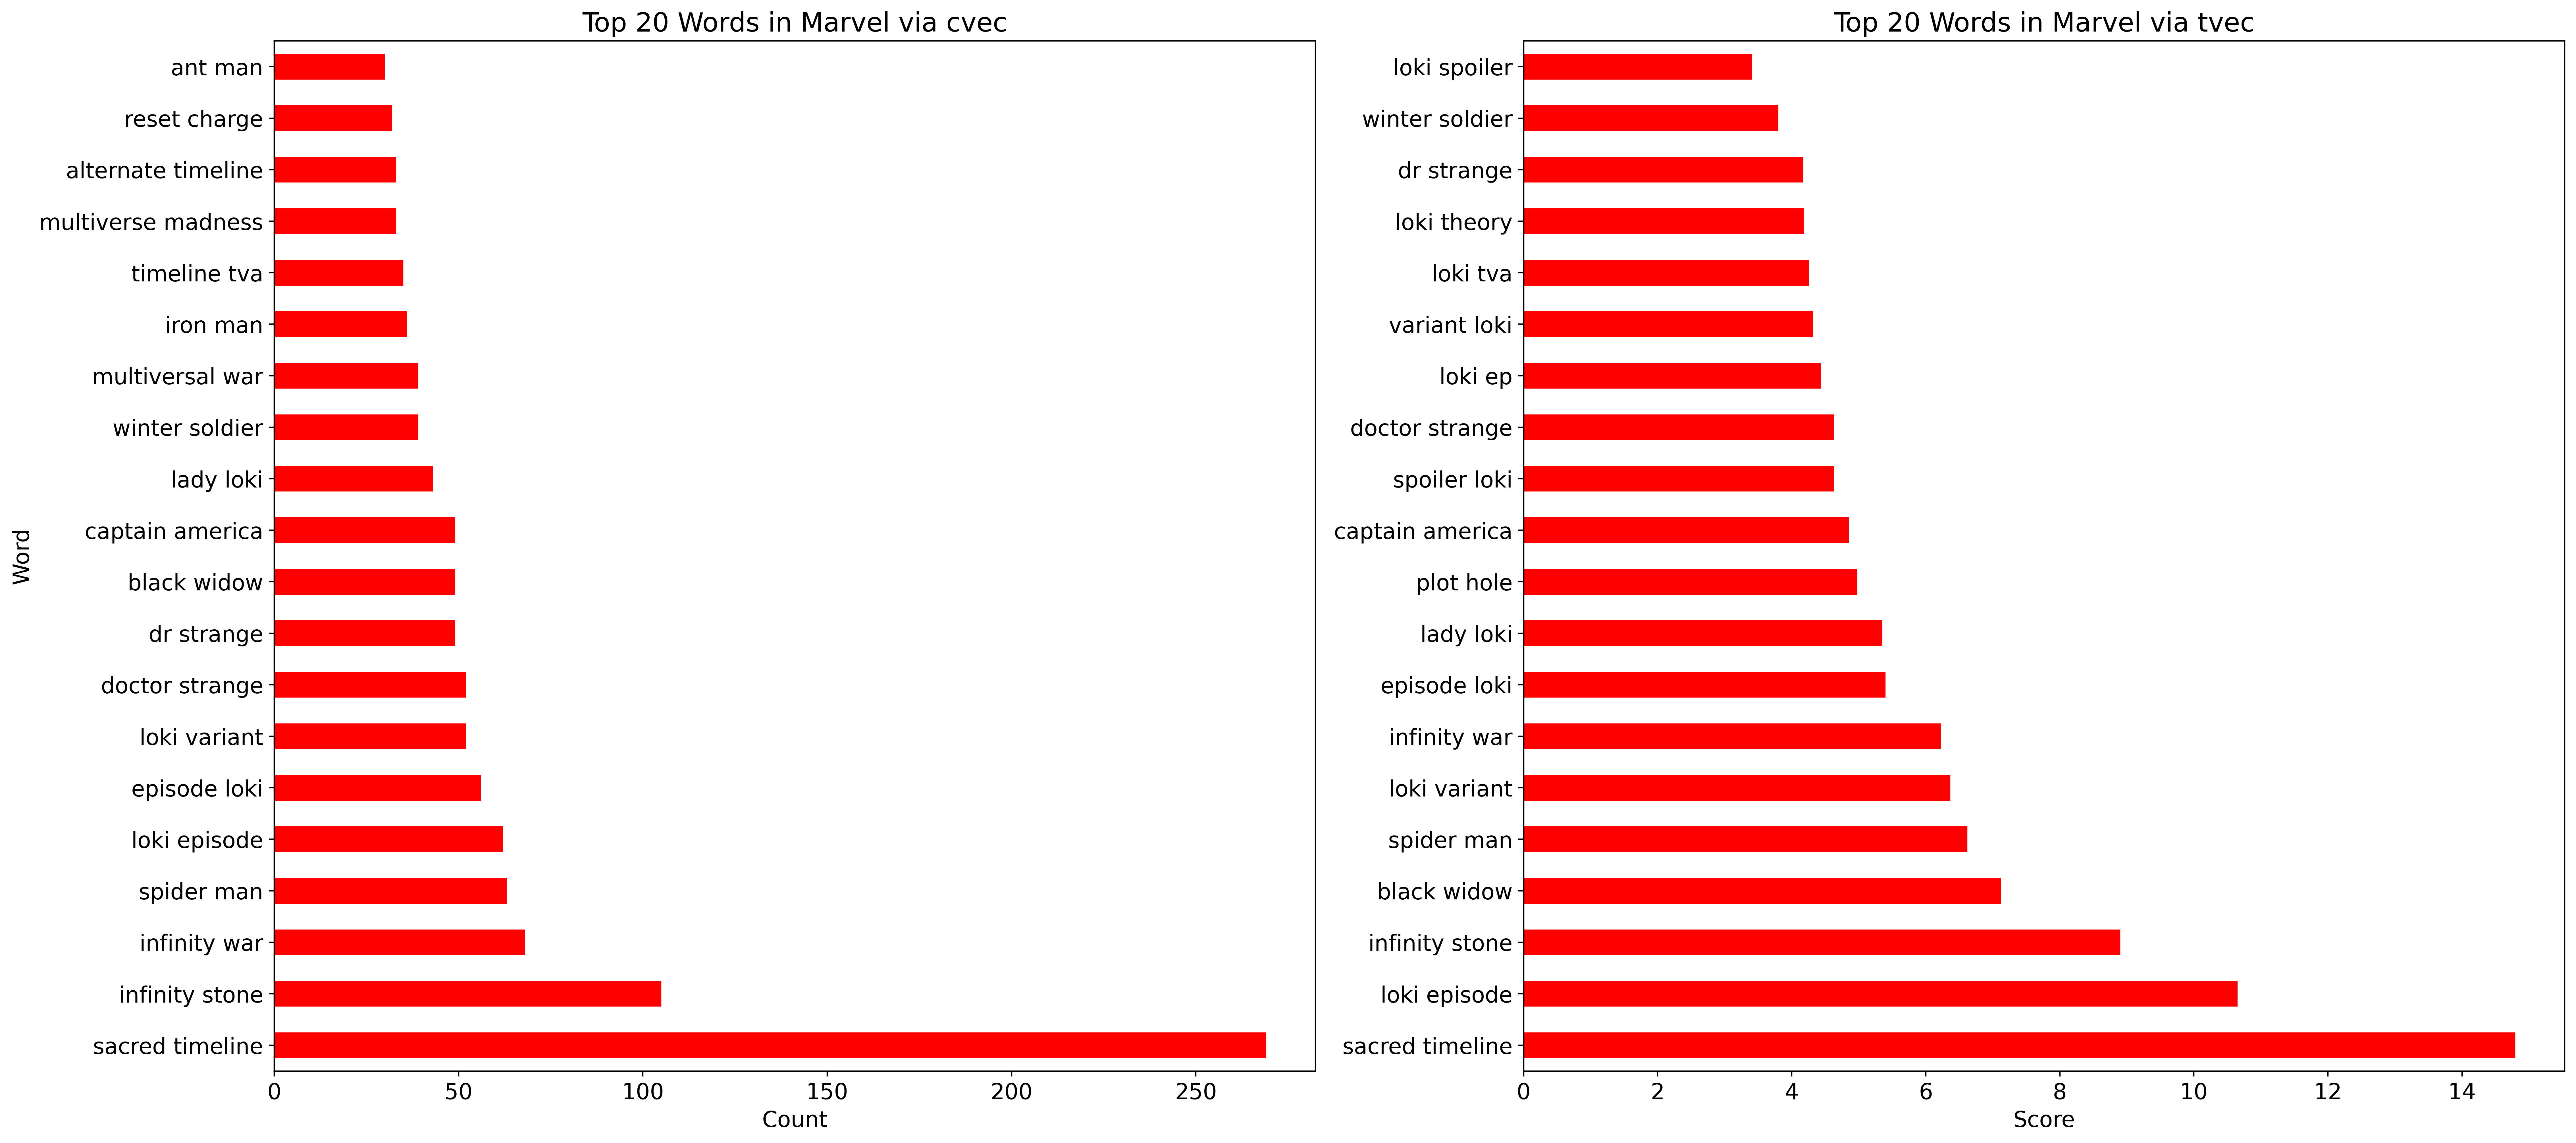

In [39]:
input_marvel=df[df['target']==1]['text_clean']

# CountVectorizer
# Fit transform & Get feature names
marvel_cvec = pd.DataFrame(cvec.fit_transform(input_marvel).todense(), 
                          columns=cvec.get_feature_names())
# Sorting the top words by CountVectoriser
marvel_cvec.sum().sort_values(ascending=False)

# TF-IDFVectorizer
# Fit transform & Get feature names
marvel_tvec = pd.DataFrame(tvec.fit_transform(input_marvel).todense(), 
                          columns=tvec.get_feature_names())
# Sorting the top words by TF-IDFVectorizer
marvel_tvec.sum().sort_values(ascending=False)

# Plot graph for top 20 words for CountVectorizer and TF-IDFVectorizer
plt.figure(figsize=(26,12), facecolor='white', dpi=400)

# CountVectorizer on the left
plt.subplot(1,2,1)
marvel_cvec.sum().sort_values(ascending=False).head(20).plot(kind='barh', cmap='hsv')
plt.title('Top 20 Words in Marvel via cvec')
plt.xlabel('Count')
plt.ylabel('Word')
plt.rc('font',size=14)


# TF-IDFVectoriser on the right
plt.subplot(1,2,2)
marvel_tvec.sum().sort_values(ascending=False).head(20).plot(kind='barh', cmap='hsv')
plt.title('Top 20 Words in Marvel via tvec')
plt.xlabel('Score')
#plt.ylabel('Word')
plt.rc('font',size=14)

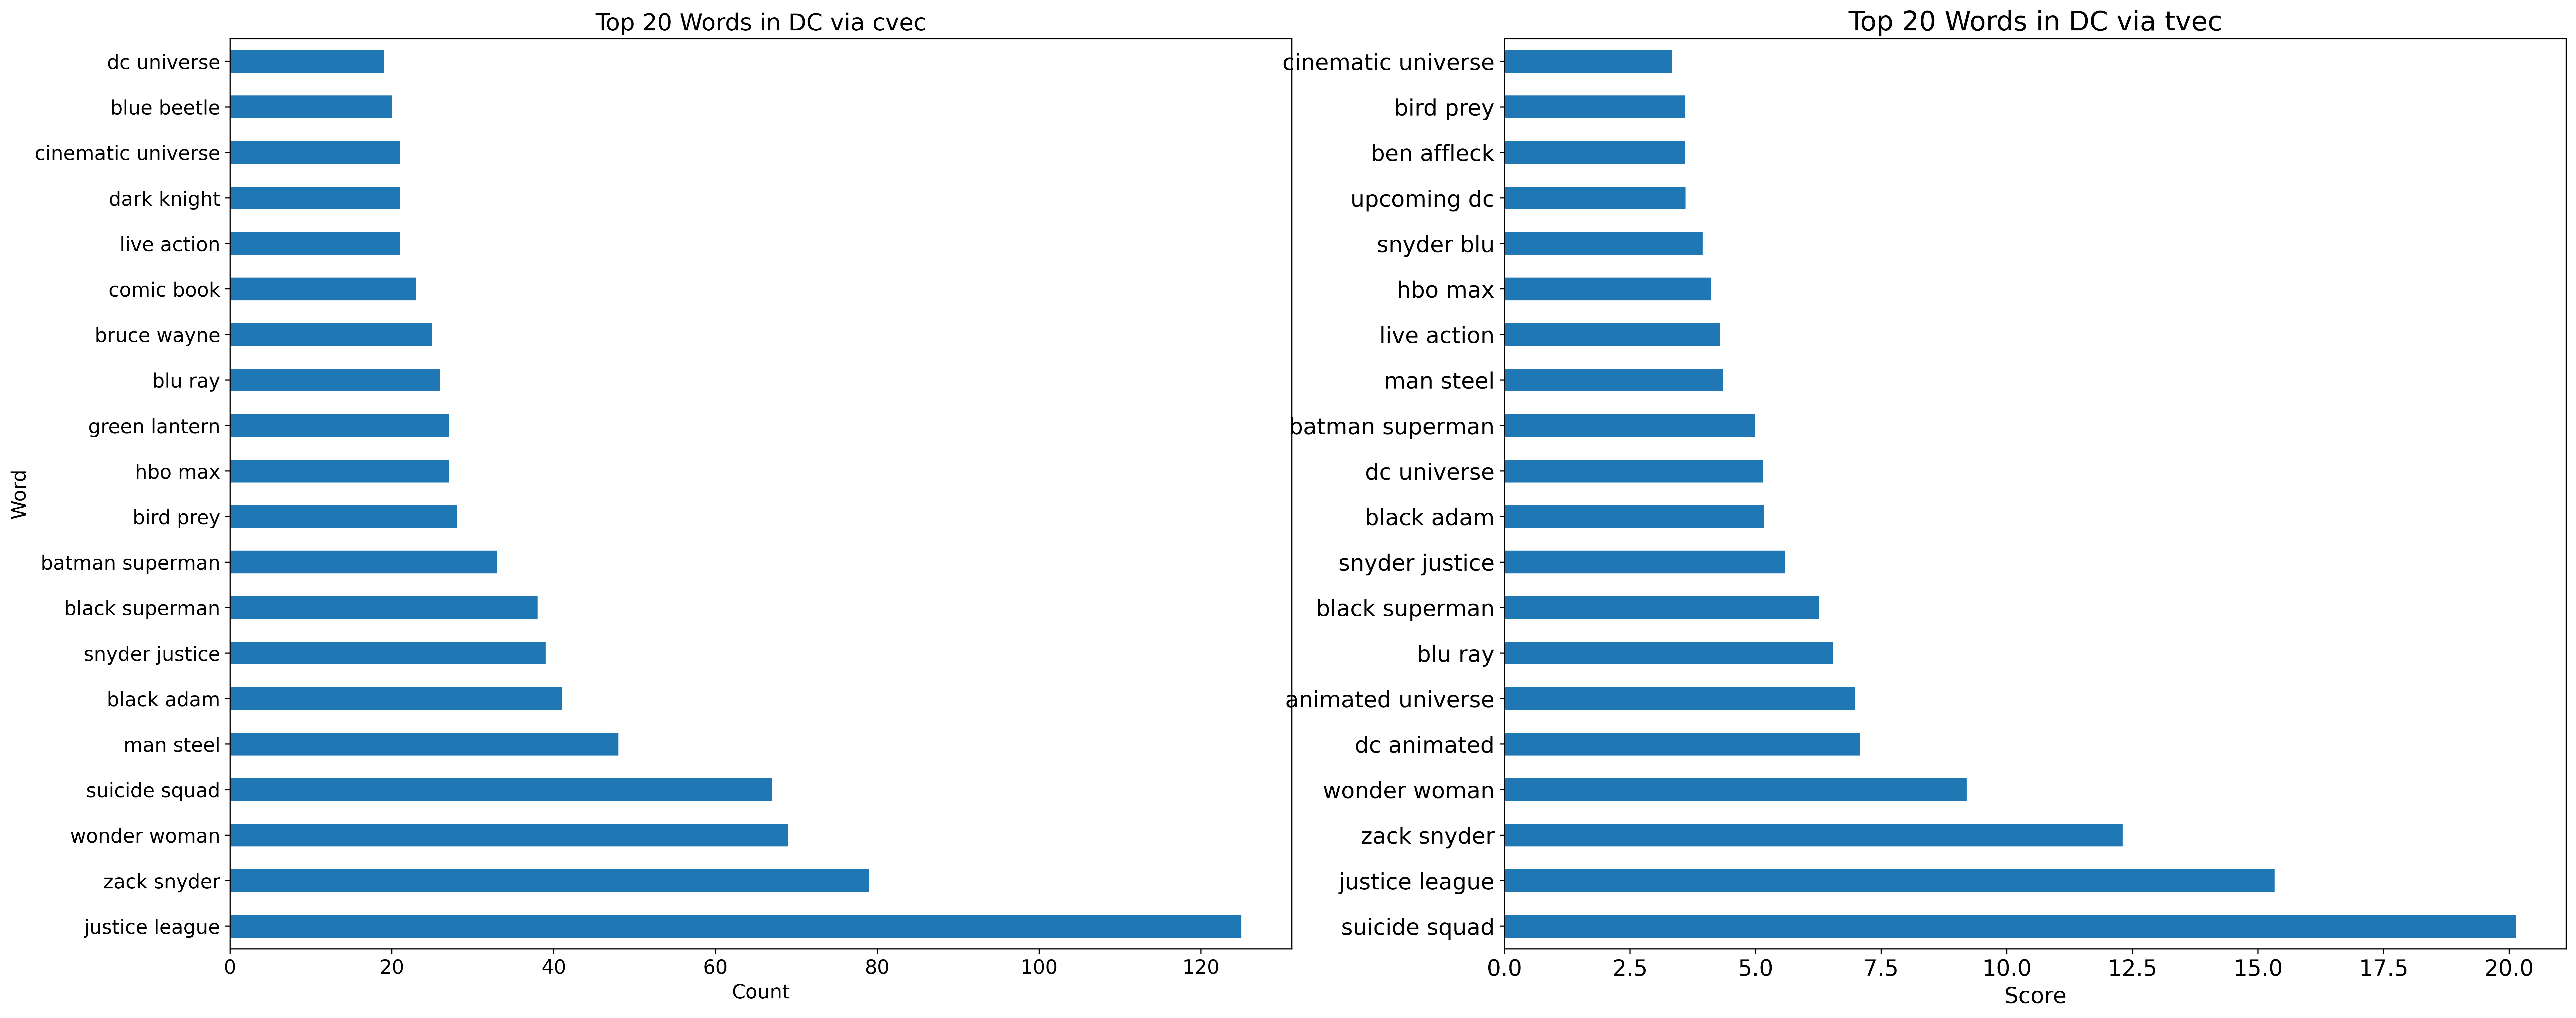

In [40]:
input_dc=df[df['target']==0]['text_clean']

# CountVectorizer
# Fit transform & Get feature names
dc_cvec = pd.DataFrame(cvec.fit_transform(input_dc).todense(), 
                          columns=cvec.get_feature_names())
# Sorting the top words by CountVectoriser
dc_cvec.sum().sort_values(ascending=False)

# TF-IDFVectorizer
# Fit transform & Get feature names
dc_tvec = pd.DataFrame(tvec.fit_transform(input_dc).todense(), 
                          columns=tvec.get_feature_names())
# Sorting the top words by TF-IDFVectorizer
dc_tvec.sum().sort_values(ascending=False)

# Plot graph for top 20 words for CountVectorizer and TF-IDFVectorizer
plt.figure(figsize=(30,12), facecolor='white', dpi=400)

# CountVectorizer on the left
plt.subplot(1,2,1)
dc_cvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Words in DC via cvec')
plt.xlabel('Count')
plt.ylabel('Word')
plt.rc('font',size=16)


# TF-IDFVectoriser on the right
plt.subplot(1,2,2)
dc_tvec.sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Top 20 Words in DC via tvec')
plt.xlabel('Score')
#plt.ylabel('Word')
plt.rc('font',size=16)

#### Observations: 
- The top 10 words and 2-words from each of the subreddits are different and relatable to the category. 
- 2-gram EDA further help to understand the popularity of the hero. 
- We are able to identify popular heros like zack snyder, wonderwoman, loki, dr strange etc which are helpful to the client. 
- This will be helpful to identify keywords and learn the model.
- We can also use the highest count superhero to answer the problem statement where the client would like to know the heros to be included in the game.


## Modelling and GridSearch

In [41]:
# Set up X ,y
X = df['text_clean']
y = df['target']

y.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

The baseline of the model is 0.5 as there is an equal balance of class.

In [42]:
# Train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y, 
                                                    random_state=42)

#### Note: 
The type of classification: Binary classfication , text classification
<p>The chosen machine learning models are : 
<p>1. Random Forest
    - It is able to deal with high dimensional noisy data in text classification      
<p>2. Logistic Regression
    - It is simple yet effective classification algorithm used for many binary classification
<p>3. Multinomial Naives Bayes 
    - It is suitable for classification with discrete features such as word counts

In [43]:
# set pipeline
pipe = Pipeline([("vec", None), ("model", None)])

# define Parameters
# using base transformer cvec or td-idf with model and its hyperparameter
param_grid = [{"vec": [CountVectorizer(stop_words=stop_words), TfidfVectorizer(stop_words=stop_words)],
               "vec__ngram_range":[(1,1),(1,2)],
               "model": [RandomForestClassifier(random_state=42)],
              "model__max_depth":[None,1,2,3,4,5],
              "model__n_estimators":[50,100,150]
              },             
              {"vec": [CountVectorizer(stop_words=stop_words), TfidfVectorizer(stop_words=stop_words)], 
               "vec__ngram_range":[(1,1),(1,2)],
               "model": [LogisticRegression(random_state=42)],
               "model__solver":['lbfgs','liblinear'],
               "model__C":np.logspace(-10, 0, 10)
              },
              {"vec": [CountVectorizer(stop_words=stop_words), TfidfVectorizer(stop_words=stop_words)], 
               "vec__ngram_range":[(1,1),(1,2)],
               "model": [MultinomialNB()],
               "model__alpha":np.linspace(0.1,1.0,20)
              }
             ]
# scoring used for gridsearch to find the best fit combination
scoring={'AUC':'roc_auc','Accuracy':make_scorer(accuracy_score)}

# perform grid search to find best model
gs = GridSearchCV(pipe, param_grid,cv=5,scoring=scoring,refit='AUC')

In [44]:
best_model=gs.fit(X_train,y_train)

In [45]:
print("Best score: %f using %s" % (best_model.best_score_,best_model.best_params_))

Best score: 0.993737 using {'model': LogisticRegression(random_state=42, solver='liblinear'), 'model__C': 1.0, 'model__solver': 'liblinear', 'vec': TfidfVectorizer(ngram_range=(1, 2),
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...})), 'vec__ngram_range': (1, 2)}


To check if the model is overfitting via .score

In [46]:
gs.score(X_train,y_train)

0.999930612244898

In [47]:
gs.score(X_test,y_test)

0.9927333333333334

No overfitting occurs and to further check with cross_val_score

In [48]:
train_cross=cross_val_score(gs,X_train,y_train,cv=5,n_jobs = -1).mean()
train_cross

0.9935019948542936

In [49]:
test_cross=cross_val_score(gs,X_test,y_test,cv=5,n_jobs = -1).mean()
test_cross

0.9877593813980969

#### Remarks: 
- The difference is acceptable as the test score is less than 10%  of the train score. 
- No overfitting occurs for the best model.

## Evaluation of model

To check for accuracy of the predictions

In [50]:
pred=gs.predict(X_test)

In [51]:
print("Best Model test score: %0.3f" % accuracy_score(y_test,pred))

Best Model test score: 0.945


### The confusion matrix for the best model

In [52]:
#Save confusion matrix values
tn,fp,fn,tp=confusion_matrix(y_test,pred).ravel()

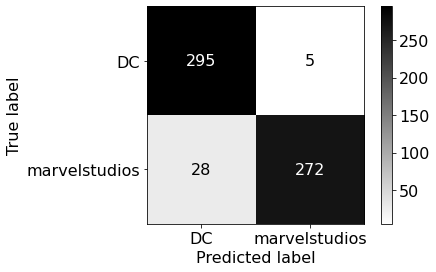

In [53]:
#Plot the confusion matrix using the plot_confusion_matrix Function
plot_confusion_matrix(gs.best_estimator_,
                      X_test,y_test,
                      display_labels=['DC','marvelstudios'],
                      cmap='binary',
                     values_format='d')

In [54]:
# Import library for scores
from sklearn.metrics import f1_score,recall_score,precision_score,roc_curve

In [55]:
# All the metrics 
score = {}

# Assign score metrics into dictionary and append to dataframe
score['Vec']=gs.best_estimator_['vec']
score['Model']=gs.best_estimator_['model']
score['Train score']=round(train_cross,3)
score['Test score']=round(test_cross,3)
score['Model Train Accuracy']= round(accuracy_score(y_train,gs.predict(X_train)),3)
score['Model Test Accuracy']= round(accuracy_score(y_test,pred),3)
score['Train ROC_AUC_score']=round(roc_auc_score(y_train,gs.predict_proba(X_train)[:,1]),3)
score['Test ROC_AUC_score']=round(roc_auc_score(y_test,gs.predict_proba(X_test)[:,1]),3)
score['Model F1 score']=round(f1_score(y_test,pred),3)
score['Specificity']=round(tn/(tn+fp),3)
score['Sensitivity/Recall']=round(recall_score(y_test,pred),3)
score['Precision']=round(precision_score(y_test,pred),3)
score['Misclassification Rate']=1-score['Model F1 score']

In [56]:
# Summary of metrics from the confusion matrix 
df_score=pd.DataFrame(score,index=['Results']).T
df_score

Results
Vec                     TfidfVectorizer(ngram_range=(1, 2),\n         ...
Model                   LogisticRegression(random_state=42, solver='li...
Train score                                                         0.994
Test score                                                          0.988
Model Train Accuracy                                                0.996
Model Test Accuracy                                                 0.945
Train ROC_AUC_score                                                     1
Test ROC_AUC_score                                                  0.993
Model F1 score                                                      0.943
Specificity                                                         0.983
Sensitivity/Recall                                                  0.907
Precision                                                           0.982
Misclassification Rate                                              0.057

#### Note: 
We are only focusing on accuracy score and ROC AUC score.
- Why choose accuracy score? 
    + our focus is on true positive and true negative which in our case, correctly predicting marvel or dc fan
- Why choose ROC AUC score?
    + we are equally focusing on positive and negative classes.
    + predict_proba is used because it is a binary classification.
    + Taken from sklearn "In the binary case, it corresponds to an array of shape (n_samples,). Both probability estimates and non-thresholded decision values can be provided. The probability estimates correspond to the probability of the class with the greater label, i.e. estimator.classes_[1] and thus estimator.predict_proba(X, y)[:, 1]. "

<Figure size 8000x4000 with 0 Axes>

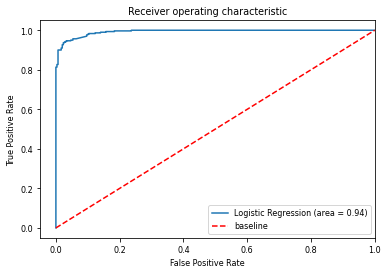

In [67]:
# Plot ROC curve
plt.figure(figsize=(20,10), facecolor='white', dpi=400)
logit_roc_auc = roc_auc_score(y_test, pred)
fp, tp, thresholds = roc_curve(y_test, gs.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fp, tp, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--',label='baseline')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
plt.rc('font',size=8);

In [58]:
log_coef=np.exp(gs.best_estimator_['model'].coef_)

In [59]:
log_coef

array([[0.69992043, 1.00009253, 1.00009253, ..., 0.95817874, 1.22844752,
        1.22844752]])

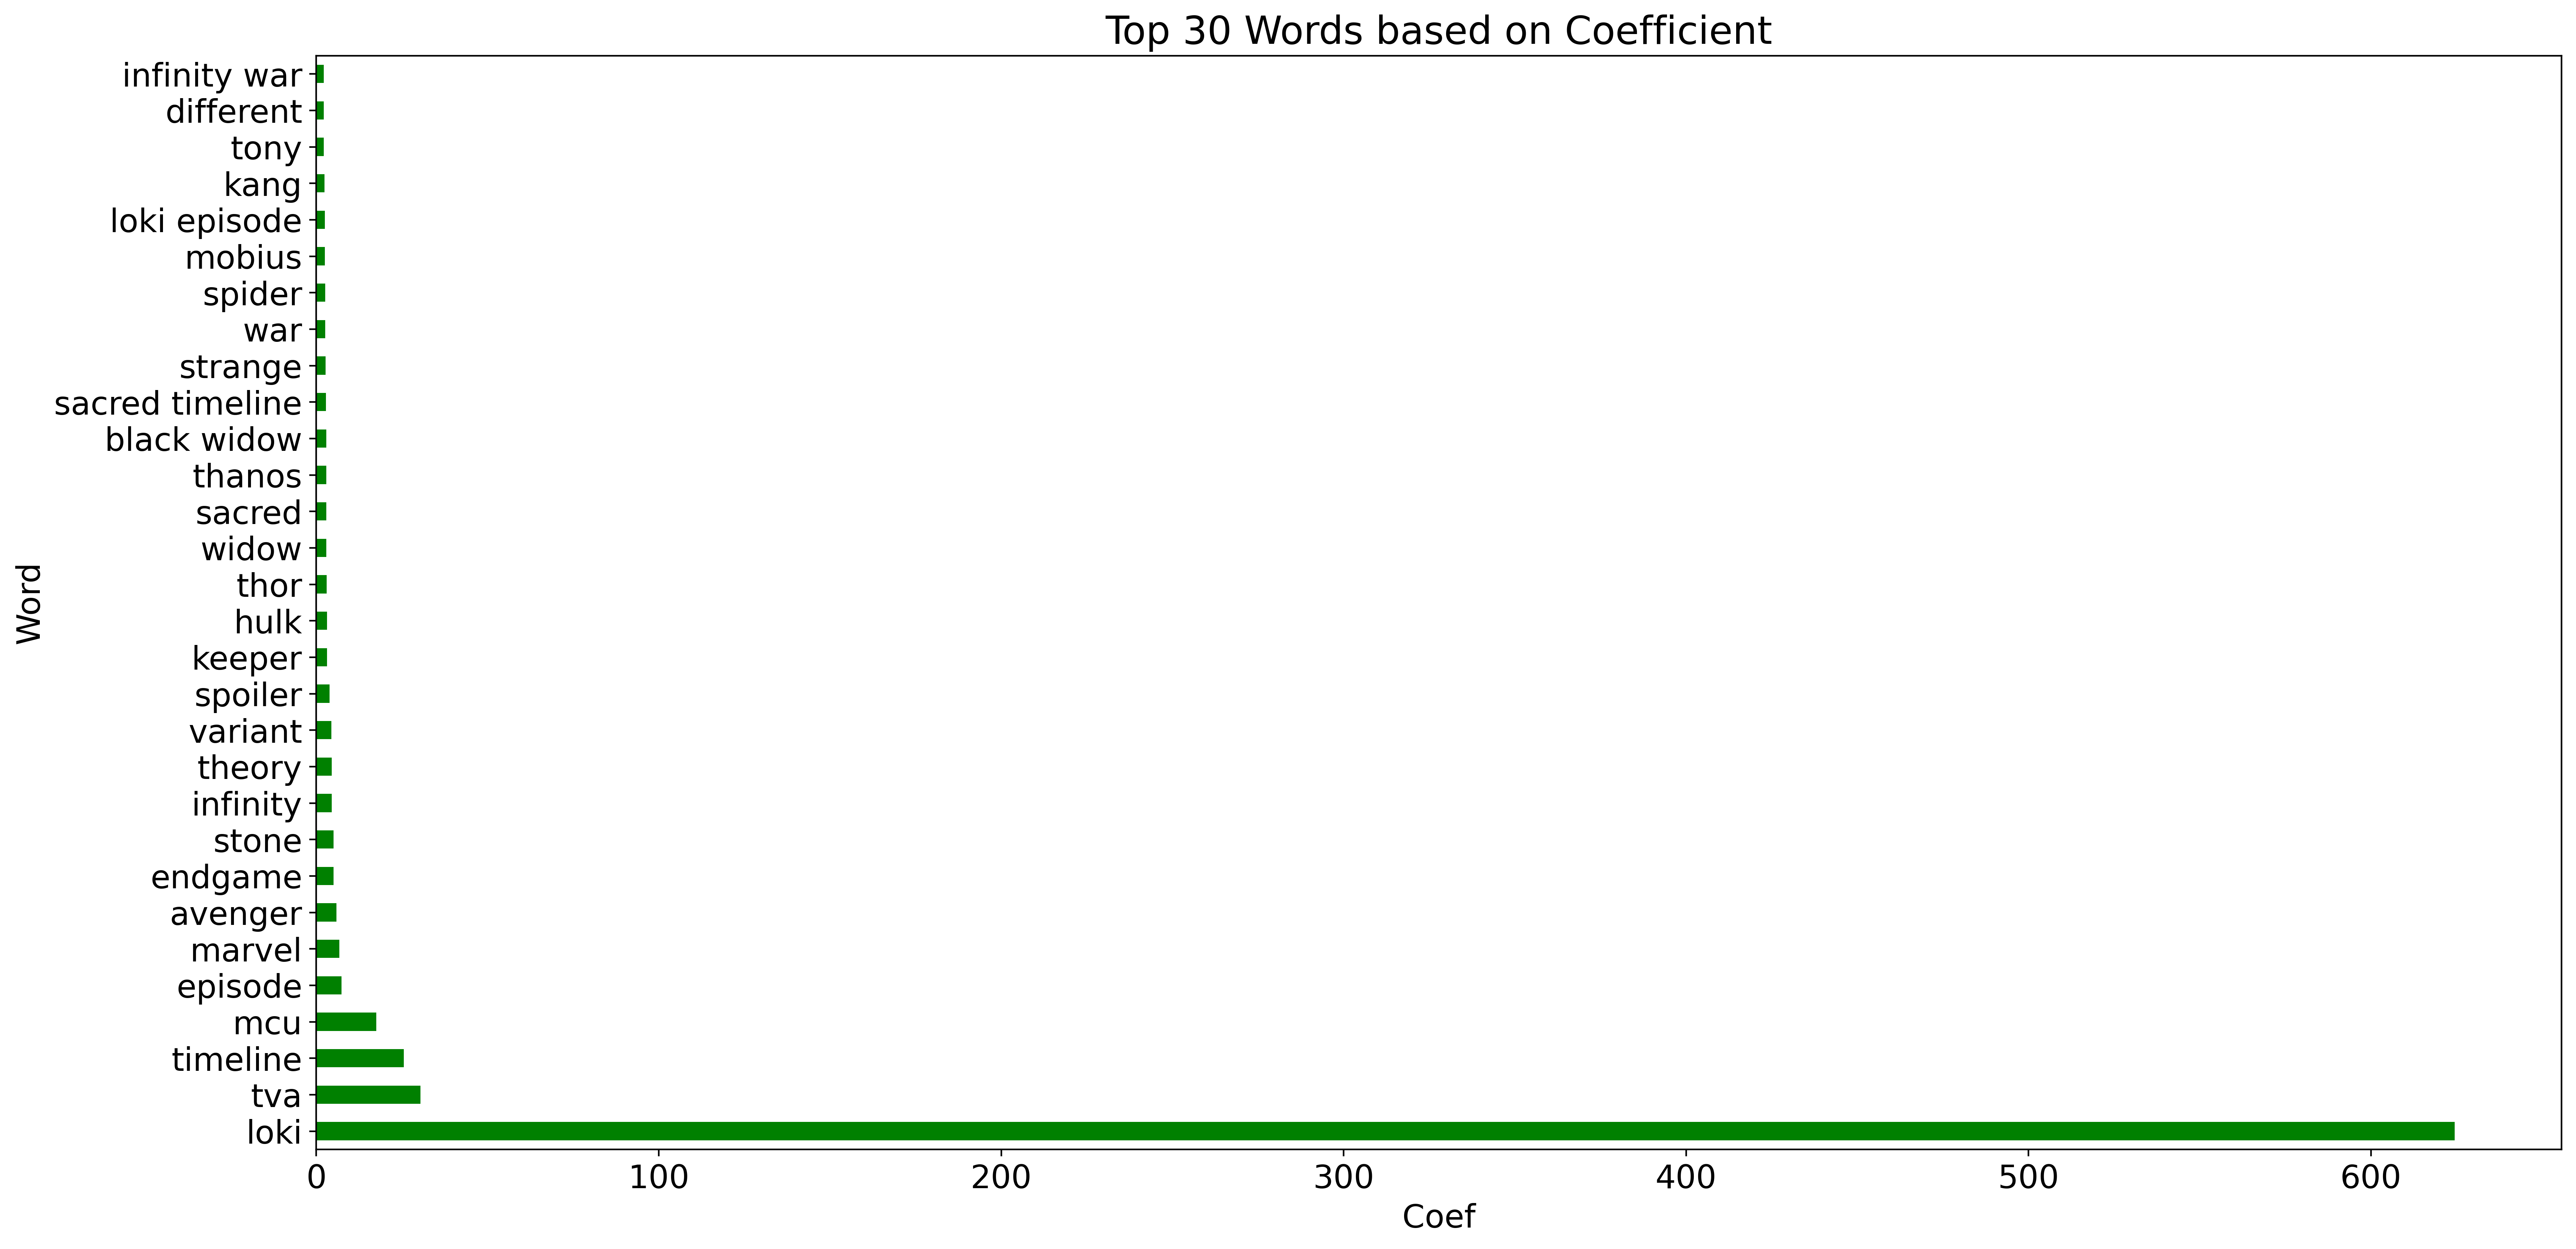

In [65]:
coefs = pd.DataFrame(
    np.abs(log_coef),
    columns=gs.best_estimator_['vec'].get_feature_names(),
    index = ['Coefficients']
)
plt.figure(figsize=(20,10), facecolor='white', dpi=400)
coefs.sum().sort_values(ascending=False).head(30).plot(kind='barh',cmap='ocean')
plt.title('Top 30 Words based on Coefficient')
plt.xlabel('Coef')
plt.ylabel('Word')
plt.rc('font',size=16)

In [61]:
# Get most important words based on coefficients of the logistic regression model
# To check if the coefficient make sense with the class
def get_important_features_lr(vectoriser, estimator, n):
    feature_names = pd.DataFrame(gs.best_estimator_['vec'].get_feature_names(), columns=['feature_name'])
    df_coef = pd.DataFrame(log_coef)
    df_coef = df_coef.T
    df_coef = pd.concat([df_coef, feature_names], axis=1)
    df_coef = df_coef.rename(columns={0:'value'})
    return df_coef.sort_values(by='value', ascending=True)[:20], df_coef.sort_values(by='value', ascending=False)[:20] 

In [62]:
df_coef_DC, df_coef_marvel = get_important_features_lr(gs.best_estimator_['vec'], 
                                                       gs.best_estimator_['model'], 20)

In [63]:
df_coef_marvel

value feature_name
21809  624.499219         loki
40287   30.448161          tva
38880   25.519364     timeline
23940   17.494195          mcu
11831    7.341929      episode
23538    6.709484       marvel
2377     5.862763      avenger
11474    5.032587      endgame
36208    5.019796        stone
18572    4.478310     infinity
38385    4.473510       theory
41533    4.443356      variant
35479    3.814847      spoiler
19929    3.140357       keeper
17719    3.093942         hulk
38559    3.028859         thor
43211    2.959312        widow
32539    2.932942       sacred
38194    2.875792       thanos
3928     2.872885  black widow

In [64]:
df_coef_DC

value    feature_name
8825   0.027112              dc
3069   0.034705          batman
37089  0.053410        superman
8965   0.068013            dceu
34810  0.080221          snyder
42843  0.175499              wb
19605  0.201029           joker
14016  0.204149           flash
20815  0.227117          league
19787  0.252705         justice
19791  0.285094  justice league
34920  0.297728     snyderverse
44334  0.307428            zsjl
44216  0.323624            zack
35603  0.326910           squad
36927  0.341385         suicide
36929  0.342316   suicide squad
43467  0.358161           woman
43560  0.364324    wonder woman
42550  0.371661          warner

#### Observations: 

- TF-IDF Vectorizer with Logistic regression perform the best which correctly predicts about 95% of the observations. 
- The model is performing better than the baseline score that calculated to be 50%.
- The Logistic regression is very much interpretable considering the business needs and explanation regarding how the model works concerning different independent variables used in the model. 
- The difference between R2 score and cross-validation score of train dataset and test dataset are less than 10% of train score, thus we can conclude that there is no overfitting issue for the model. 
- From the confusion matrix, we are able to identify 295 out of 300 are correct predictions for DC and 270 out of 300 are correct predictions for Marvel. 
- 30 wrong predictions are predicted to be Marvel when in reality, it belongs to DC.
- 5 from DC are wrongly predicted to be Marvel.
- The misclassification rate is about 6%.
- This could be due to the common words that they used or users have posted DC related in marvel subreddit and vice versa. 
- By taking the coeff of the logistic regression, we are able to identify more important key words that the model used for classification.

## Conclusion and Recommendation

The classification model to differentiate between Marvel and DC fans can be modelled with high accuracy by using Tf-IDF Vectorizer with Logistic Regression Model. 

The following are the summary of steps that was taken to derive at the final model:
+ Data Collection via PushshiftAPI
    - Make sure that response status code is 200 which means the process is successful
+ Exploratory data analysis (EDA)
+ Data Cleaning and Pre-processing text data
    - Regular expression to clean data
    - Tokenizing
    - Lemmatizing
    - Stop word removal
+ Modeling
    - Choice of Vectorizer : CountVectorizer and TF-IDF Vectorizer
    - Choice of Classification Model: 
        - Random Forest Classifier
        - Logistic Regression 
        - Multinomial Naives Bayes 
    - GridSearch for best paramter and its hyperparameter tuning
+ Evaluation 
    - Confusion Matrix
    - R2 score and cross validation score
    - Accuracy score
    
In conclusion, the accuracy score is about 95% and roc auc score of the model is about 99%. With the classification model, it can be used to target the right audience group to display appropriate advertisement to entice the users to download the game application in order to boost the game popularity.

The top 5 from each team that are recommended to be included in the game:
- Spiderman
- Loki
- Dr Strange
- Black Widow
- Captain America
- Wonder woman
- Superman
- Black adam
- Bat man
- Green Lantern

The benefit of the model: 
1. Primary Stakeholder: Client to achieve a successful marketing campaign 
2. Secondary Stakeholder: Consumers get to play their favourite character in the game 

## Limitation

The model limited to Reddit data and data was limited to the most recent 1000 posts per subreddit.
<p>We suggest to collect more sample data from other social media such as Twitter and for a longer period of time ideally more than 3 months to further improve the model. 
<p>Besides that, with the upcoming tv series and movies, it is recommended to retrain the model on monthly basis.